In [30]:
%run setup.py

# Read in data

## Read catalog data

In [31]:
stars = pd.read_excel(rootpath+'surface/sample/samples.xlsx')
idx = (stars['ifmodelling']==1)
stars = stars.loc[idx,:].reset_index(drop=True)

modes = pd.read_excel(rootpath+'surface/sample/modes.xlsx')

## Retrieve modelling results

In [32]:
def retrieve_data_to_table(table, filepath, tcols, dcols):
    Ncol = len(tcols)
    for istar, star in table.iterrows():
        for icol in range(Ncol):
            file = filepath.format(star['KIC'])
            if not os.path.exists(file): continue
            data=ascii.read(file, delimiter=',')
            table.loc[istar, tcols[icol]] = data[dcols[icol]][1]
            table.loc[istar, 'e_'+tcols[icol]] = (data[dcols[icol]][2]-data[dcols[icol]][0])/2.
    return table

data_cols = ['star_mass', 'numax_scaling', 'radius', 'star_age', 'delta_nu_scaling', 'Dnu_freq', 'Teff', 'FeH', 'amlt', 'Yinit', 'luminosity']
table_cols = ['mass', 'numax', 'radius', 'age', 'Dnu_scaling','Dnu_freq', 'Teff', 'FeH', 'amlt', 'Yinit', 'luminosity']

data_col_names = data_cols
table_col_names = [t+'_mc' for t in table_cols]
filepath = rootpath+'hpc/results_cubic/{:09.0f}/summary_prob.txt'
stars = retrieve_data_to_table(stars, filepath, table_col_names, data_col_names)

data_col_names = data_cols
table_col_names = [t+'_mcp' for t in table_cols]
filepath = rootpath+'hpc/results_sc_cubic_linear_ind/{:0.0f}/summary_prob.txt'
stars = retrieve_data_to_table(stars, filepath, table_col_names, data_col_names)

data_col_names = data_cols
table_col_names = [t+'_mic' for t in table_cols]
filepath = rootpath+'hpc/results_combined/{:09.0f}/summary_prob.txt'
stars = retrieve_data_to_table(stars, filepath, table_col_names, data_col_names)

data_col_names = data_cols
table_col_names = [t+'_micp' for t in table_cols]
filepath = rootpath+'hpc/results_sc_combined_linear_ind/{:0.0f}/summary_prob.txt'
stars = retrieve_data_to_table(stars, filepath, table_col_names, data_col_names)


# data_col_names = data_cols
# table_col_names = [t+'_cubic_wo_L' for t in table_cols]
# filepath = rootpath+'hpc/results_cubic_wo_L/{:09.0f}/summary_prob.txt'
# stars = retrieve_data_to_table(stars, filepath, table_col_names, data_col_names)

# data_col_names = data_cols
# table_col_names = [t+'_cubic_linear_wo_L' for t in table_cols]
# filepath = rootpath+'hpc/results_sc_cubic_linear_wo_L/{:09.0f}/summary_prob.txt'
# stars = retrieve_data_to_table(stars, filepath, table_col_names, data_col_names)


for suffix in ['_mc', '_mcp', '_mic', '_micp']: #, '_cubic_wo_L', '_cubic_linear_wo_L']: #, '_combined_linear']: #
    gval = 'g'+suffix
    dval = 'density'+suffix
    mval = 'mass'+suffix
    rval = 'radius'+suffix
    e_gval = 'e_g'+suffix
    e_dval = 'e_density'+suffix
    e_mval = 'e_mass'+suffix
    e_rval = 'e_radius'+suffix
    stars[gval] = stars[mval]/stars[rval]**2.
    stars[e_gval] = ((stars[e_mval]/stars[mval])**2.0 \
                      + (2*stars[e_rval]/stars[rval])**2.0)**0.5 * stars[gval]
    stars[dval] = stars[mval]/stars[rval]**3.
    stars[e_dval] = ((stars[e_mval]/stars[mval])**2.0 \
                      + (3*stars[e_rval]/stars[rval])**2.0)**0.5 * stars[dval]

KeyboardInterrupt: 

# Test on clusters
## NGC6791

### histogram on age, Y, and amlt

In [3]:
idx = np.isin(stars['names'], ['ngc6791']) & (stars['ruwe']<1.2)#ngc6
sample = stars.loc[idx,:].reset_index(drop=True)

In [15]:
stars.loc[np.isin(stars['names'], ['ngc6791', 'ngc6819']) & (stars['ifmodelling']==1), ['KIC', 'names', '[M/H]', 'ebv']].groupby('names').mean()

,KIC,[M/H],ebv
names,,,
ngc6791,2.461767e+06,0.36,0.172593
ngc6819,5.048894e+06,0.06,0.066659


The reduction of scatter in age is not good - probably because each star has its own large uncertainty.

Try combined measurements - helium/age?

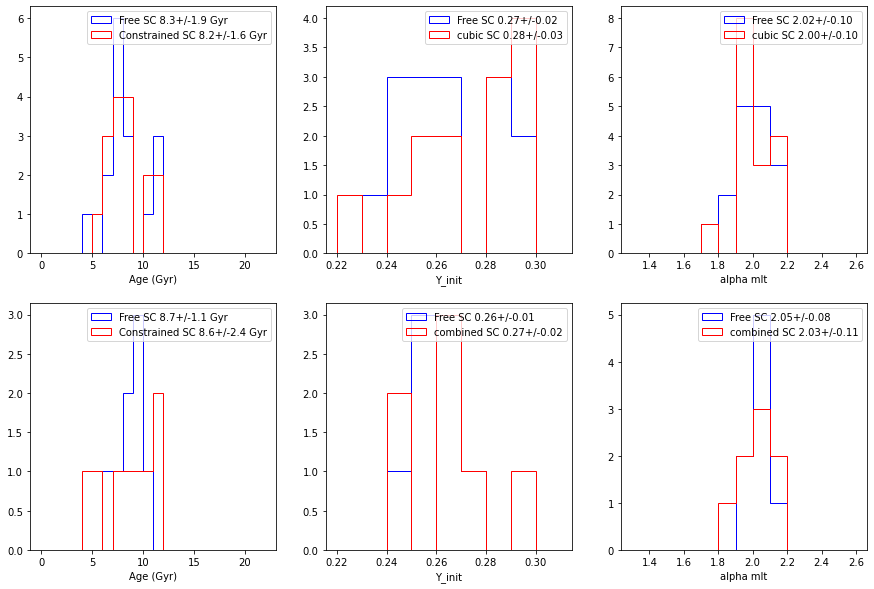

In [145]:
fig, axes = plt.subplots(figsize=(15,10), nrows=2, ncols=3, squeeze=False)
# axes=axes.reshape(-1)

suffixes = ['cubic', 'combined']

for i in range(2):
    suf = suffixes[i]
    
    idx = ((sample['age_{:s}'.format(suf)]/1e9) <18) & ((sample['e_age_{:s}'.format(suf)]/sample['age_{:s}'.format(suf)])<0.5) \
         &((sample['age_{:s}_linear'.format(suf)]/1e9) <18) & ((sample['e_age_{:s}_linear'.format(suf)]/sample['age_{:s}_linear'.format(suf)])<0.5)  # 

    bin_age=np.arange(0,2.25e10/1e9,1)
    hist1 = {"bins":bin_age,"histtype":"step","color":'b',"label":"Free SC {:0.1f}+/-{:0.1f} Gyr".format(np.mean(sample.loc[idx,'age_{:s}'.format(suf)]/1e9), np.std(sample.loc[idx,'age_{:s}'.format(suf)]/1e9))}
    hist2 = {"bins":bin_age,"histtype":"step","color":'r',"label":"Constrained SC {:0.1f}+/-{:0.1f} Gyr".format(np.mean(sample.loc[idx,'age_{:s}_linear'.format(suf)]/1e9), np.std(sample.loc[idx,'age_{:s}_linear'.format(suf)]/1e9))}
    axes[i,0].hist(sample.loc[idx,'age_{:s}'.format(suf)]/1e9, **hist1)
    axes[i,0].hist(sample.loc[idx,'age_{:s}_linear'.format(suf)]/1e9, **hist2)

    bin_yinit=np.arange(0.22, 0.32, 0.01)
    hist1 = {"bins":bin_yinit,"histtype":"step","color":'b',"label":"Free SC {:0.2f}+/-{:0.2f}".format(np.mean(sample.loc[idx,'Yinit_{:s}'.format(suf)]), np.std(sample.loc[idx,'Yinit_{:s}'.format(suf)]))}
    hist2 = {"bins":bin_yinit,"histtype":"step","color":'r',"label":"{:s} SC {:0.2f}+/-{:0.2f}".format(suf, np.mean(sample.loc[idx,'Yinit_{:s}_linear'.format(suf)]), np.std(sample.loc[idx,'Yinit_{:s}_linear'.format(suf)]))}
    axes[i,1].hist(sample.loc[idx,'Yinit_{:s}'.format(suf)], **hist1)
    axes[i,1].hist(sample.loc[idx,'Yinit_{:s}_linear'.format(suf)], **hist2)

    bin_amlt=np.arange(1.3, 2.7, 0.1)
    hist1 = {"bins":bin_amlt,"histtype":"step","color":'b',"label":"Free SC {:0.2f}+/-{:0.2f}".format(np.mean(sample.loc[idx,'amlt_{:s}'.format(suf)]), np.std(sample.loc[idx,'amlt_{:s}'.format(suf)]))}
    hist2 = {"bins":bin_amlt,"histtype":"step","color":'r',"label":"{:s} SC {:0.2f}+/-{:0.2f}".format(suf, np.mean(sample.loc[idx,'amlt_{:s}_linear'.format(suf)]), np.std(sample.loc[idx,'amlt_{:s}_linear'.format(suf)]))}
    axes[i,2].hist(sample.loc[idx,'amlt_{:s}'.format(suf)], **hist1)
    axes[i,2].hist(sample.loc[idx,'amlt_{:s}_linear'.format(suf)], **hist2)
    
    axes[i,0].set_xlabel('Age (Gyr)')
    axes[i,1].set_xlabel('Y_init')
    axes[i,2].set_xlabel('alpha mlt')

    axes[i,0].legend()
    axes[i,1].legend()
    axes[i,2].legend()
    

### Imposing the prior of the same Y

This does not show that the age is significantly improved. 

The problem could be the fact that there is variation in Yinit.

Here I will try to make a new condition that the Yinit is the same across all cluster stars.

In [10]:
idx = np.isin(stars['names'], ['ngc6791']) & (stars['ruwe']<1.2)#ngc6
sample = stars.loc[idx,:].reset_index(drop=True)

In [11]:
probs, Yinits, ages = [[] for i in range(3)]
for istar, star in sample.loc[:,:].iterrows():
    data = h5py.File(work_dir+'../hpc/results_cubic/{:09.0f}/data.h5'.format(star['KIC']), 'r')
    
    cols = ['prob', 'Yinit', 'star_age']
    prob, Yinit, age = [data[col][:] for col in cols]
    prob = prob#/np.sum(prob)
    
    probs.append(prob)
    Yinits.append(Yinit)
    ages.append(age)
#     samples = np.transpose(np.array([Yinit, star_age]))
#     results = se.quantile(samples, (0.16, 0.5, 0.84), weights=prob)

In [12]:
Nstar = len(probs)
# Y_bins = np.linspace(0.25, 0.30, 11)
# t_bins = np.linspace(0,20e9,20) #/1e9

t = np.linspace(0,20e9,100)
prob_t = [np.zeros(len(t)) for i in range(Nstar)]

Y = np.linspace(0.22,0.32,30)
prob_Y = [np.zeros(len(Y)) for i in range(Nstar)]

prob_t_Y = [np.zeros((len(t), len(Y))) for i in range(Nstar)]

from sklearn.neighbors import KernelDensity

for istar in range(Nstar):
    idx = probs[istar]>0
    
    kde = KernelDensity(kernel='gaussian', bandwidth=1e9).fit(ages[istar][idx][:,None], None, probs[istar][idx])
    prob_t[istar] = np.exp(kde.score_samples(t[:, None]))
    
    kde = KernelDensity(kernel='gaussian', bandwidth=0.01).fit(Yinits[istar][idx][:,None], None, probs[istar][idx])
    prob_Y[istar] = np.exp(kde.score_samples(Y[:, None]))
    
    sample = np.array([[tt/1e9, tY/0.01] for tt in t for tY in Y])
    kde = KernelDensity(kernel='gaussian', bandwidth=1.0).fit(np.array([ages[istar][idx]/1e9, Yinits[istar][idx]/0.01]).T,
                                                            None, probs[istar][idx])
    prob_t_Y[istar] = np.exp(kde.score_samples(sample))

In [13]:
joint2_prob_t = np.zeros(len(t))
for iY in range(len(Y)):
    idx = (((sample[:,1]*0.01)-Y[iY])**2. <0.0000001)
    joint2_prob_t_iY = np.ones(len(t))
    for istar in range(Nstar):
        joint2_prob_t_iY *= prob_t_Y[istar][idx]
    joint2_prob_t += joint2_prob_t_iY

In [14]:
# plt.scatter(sample[:,0], sample[:,1]*0.01, c=prob_t_Y[10])

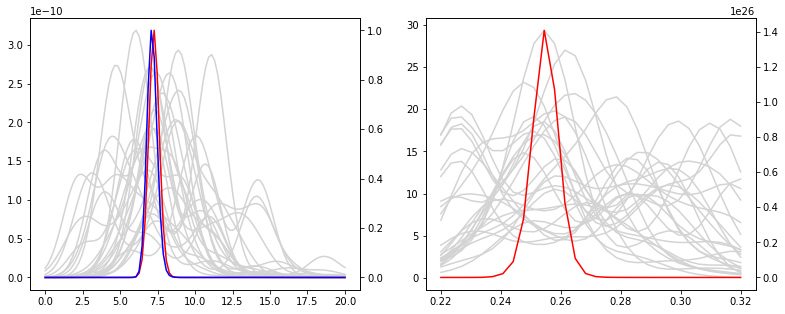

In [15]:
fig, axes = plt.subplots(figsize=(13,5), nrows=1, ncols=2, squeeze=False)
axes = axes.reshape(-1)

joint_prob_t = np.ones(len(t))
joint_prob_Y = np.ones(len(Y))
for istar in range(Nstar):
    joint_prob_t *= prob_t[istar]
    joint_prob_Y *= prob_Y[istar]
    axes[0].plot(t/1e9, prob_t[istar], color='lightgray')
    axes[1].plot(Y, prob_Y[istar], color='lightgray')
    
twax0 = axes[0].twinx()
twax0.plot(t/1e9, joint_prob_t/np.max(joint_prob_t), color='red')
twax0.plot(t/1e9, joint2_prob_t/np.max(joint2_prob_t), color='blue')

twax1 = axes[1].twinx()
twax1.plot(Y, joint_prob_Y, color='red')

### KDE on age

It looks like the initial helium abundance is not the culprit.

Try use kde instead of histogram?

#### cubic

In [16]:
idx = np.isin(stars['names'], ['ngc6791']) & (stars['ruwe']<1.2)#ngc6
sample = stars.loc[idx,:].reset_index(drop=True)

probs1, Yinits1, ages1 = [[] for i in range(3)]
probs2, Yinits2, ages2 = [[] for i in range(3)]
for istar, star in sample.loc[:,:].iterrows():
    
    cols = ['prob', 'Yinit', 'star_age']
    
    data = h5py.File(work_dir+'../hpc/results_cubic/{:09.0f}/data.h5'.format(star['KIC']), 'r')
    prob, Yinit, age = [data[col][:] for col in cols]
    
    probs1.append(prob)
    Yinits1.append(Yinit)
    ages1.append(age)

    data = h5py.File(work_dir+'../hpc/results_sc_cubic_linear/{:09.0f}/data.h5'.format(star['KIC']), 'r')
    prob, Yinit, age = [data[col][:] for col in cols]
    
    probs2.append(prob)
    Yinits2.append(Yinit)
    ages2.append(age)

In [17]:
Nstar = len(probs1)
# Y_bins = np.linspace(0.25, 0.30, 11)
# t_bins = np.linspace(0,20e9,20) #/1e9

t = np.linspace(0,20e9,100)
prob_t1 = [np.zeros(len(t)) for i in range(Nstar)]
prob_t2 = [np.zeros(len(t)) for i in range(Nstar)]

Y = np.linspace(0.22,0.32,30)
prob_Y1 = [np.zeros(len(Y)) for i in range(Nstar)]
prob_Y2 = [np.zeros(len(Y)) for i in range(Nstar)]

from sklearn.neighbors import KernelDensity

for istar in range(Nstar):
    idx = (probs1[istar]>0) #& (Yinits1[istar]>0.23) & (Yinits1[istar]<0.28)
    
    kde = KernelDensity(kernel='gaussian', bandwidth=1e9).fit(ages1[istar][idx][:,None], None, probs1[istar][idx])
    prob_t1[istar] = np.exp(kde.score_samples(t[:, None]))
    
    kde = KernelDensity(kernel='gaussian', bandwidth=0.01).fit(Yinits1[istar][idx][:,None], None, probs1[istar][idx])
    prob_Y1[istar] = np.exp(kde.score_samples(Y[:, None]))

    idx = (probs2[istar]>0) #& (Yinits2[istar]>0.23) & (Yinits2[istar]<0.28)
    
    kde = KernelDensity(kernel='gaussian', bandwidth=1e9).fit(ages2[istar][idx][:,None], None, probs2[istar][idx])
    prob_t2[istar] = np.exp(kde.score_samples(t[:, None]))
    
    kde = KernelDensity(kernel='gaussian', bandwidth=0.01).fit(Yinits2[istar][idx][:,None], None, probs2[istar][idx])
    prob_Y2[istar] = np.exp(kde.score_samples(Y[:, None]))

Text(0.5, 0, 'Yinit')

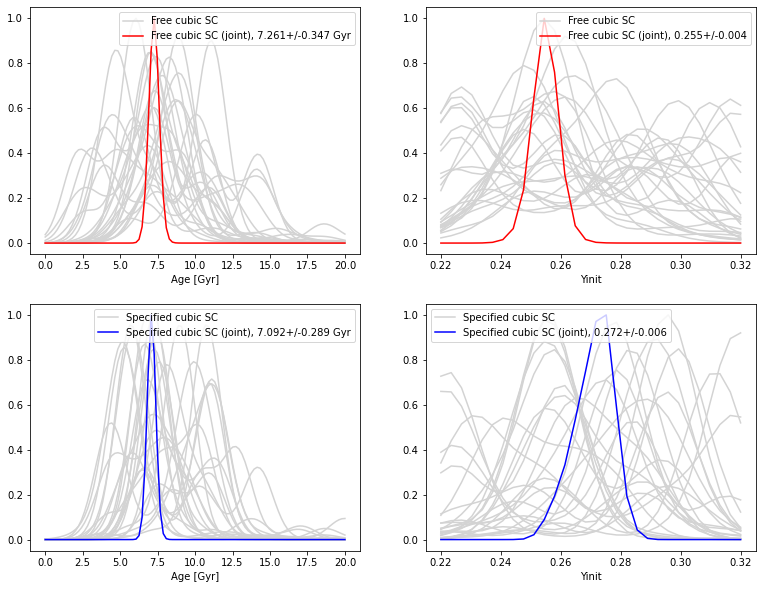

In [18]:
# program
from scipy.optimize import curve_fit

fig, axes = plt.subplots(figsize=(13,10), nrows=2, ncols=2, squeeze=False)
axes = axes.reshape(-1)

joint_prob_t1 = np.ones(len(t))
joint_prob_Y1 = np.ones(len(Y))
for istar in range(Nstar):
    joint_prob_t1 *= prob_t1[istar]
    joint_prob_Y1 *= prob_Y1[istar]

    if istar==0:
        axes[0].plot(t/1e9, prob_t1[istar]/np.max(prob_t1), color='lightgray', label='Free cubic SC')
        axes[1].plot(Y, prob_Y1[istar]/np.max(prob_Y1), color='lightgray', label='Free cubic SC')
    else:
        axes[0].plot(t/1e9, prob_t1[istar]/np.max(prob_t1), color='lightgray')
        axes[1].plot(Y, prob_Y1[istar]/np.max(prob_Y1), color='lightgray')


joint_prob_t2 = np.ones(len(t))
joint_prob_Y2 = np.ones(len(Y))
for istar in range(Nstar):
    joint_prob_t2 *= prob_t2[istar]
    joint_prob_Y2 *= prob_Y2[istar]
    if istar==0:
        axes[2].plot(t/1e9, prob_t2[istar]/np.max(prob_t2), color='lightgray', label='Specified cubic SC')
        axes[3].plot(Y, prob_Y2[istar]/np.max(prob_Y2), color='lightgray', label='Specified cubic SC')
    else:
        axes[2].plot(t/1e9, prob_t2[istar]/np.max(prob_t2), color='lightgray')
        axes[3].plot(Y, prob_Y2[istar]/np.max(prob_Y2), color='lightgray')

def gauss_function(x, a, x0, sigma):
    return a*np.exp(-(x-x0)**2/(2*sigma**2))



popt, pcov = curve_fit(gauss_function, t/1e9, joint_prob_t1/np.max(joint_prob_t1), p0=[1., t[np.argmax(joint_prob_t1)]/1e9, 0.07])
axes[0].plot(t/1e9, joint_prob_t1/np.max(joint_prob_t1), color='red', label='Free cubic SC (joint), {:0.3f}+/-{:0.3f} Gyr'.format(popt[1], np.abs(popt[2])))

popt, pcov = curve_fit(gauss_function, Y, joint_prob_Y1/np.max(joint_prob_Y1), p0=[1., Y[np.argmax(joint_prob_Y1)], 0.01])
axes[1].plot(Y, joint_prob_Y1/np.max(joint_prob_Y1), color='red', label='Free cubic SC (joint), {:0.3f}+/-{:0.3f}'.format(popt[1], np.abs(popt[2])))

popt, pcov = curve_fit(gauss_function, t/1e9, joint_prob_t2/np.max(joint_prob_t2), p0=[1., t[np.argmax(joint_prob_t2)]/1e9, 0.07])
axes[2].plot(t/1e9, joint_prob_t2/np.max(joint_prob_t2), color='blue', label='Specified cubic SC (joint), {:0.3f}+/-{:0.3f} Gyr'.format(popt[1], np.abs(popt[2])))

popt, pcov = curve_fit(gauss_function, Y, joint_prob_Y2/np.max(joint_prob_Y2), p0=[1., Y[np.argmax(joint_prob_Y2)], 0.01])
axes[3].plot(Y, joint_prob_Y2/np.max(joint_prob_Y2), color='blue', label='Specified cubic SC (joint), {:0.3f}+/-{:0.3f}'.format(popt[1], np.abs(popt[2])))

# axes[0].plot(t/1e9, joint_prob_t2/np.max(joint_prob_t2), color='blue', label='Specified cubic SC')
# axes[1].plot(Y, joint_prob_Y2/np.max(joint_prob_Y2), color='blue', label='Specified cubic SC')
# axes[2].plot(t/1e9, joint_prob_t1/np.max(joint_prob_t1), color='red', label='Free cubic SC')
# axes[3].plot(Y, joint_prob_Y1/np.max(joint_prob_Y1), color='red', label='Free cubic SC')

axes[0].legend()
axes[1].legend()
axes[2].legend()
axes[3].legend()

axes[0].set_xlabel('Age [Gyr]')
axes[1].set_xlabel('Yinit')
axes[2].set_xlabel('Age [Gyr]')
axes[3].set_xlabel('Yinit')


#### combined

In [37]:
idx = np.isin(stars['names'], ['ngc6791']) & (stars['ruwe']<1.2)#ngc6
sample = stars.loc[idx,:].reset_index(drop=True)

probs1, Yinits1, ages1 = [[] for i in range(3)]
probs2, Yinits2, ages2 = [[] for i in range(3)]
for istar, star in sample.loc[:,:].iterrows():
    
    cols = ['prob', 'Yinit', 'star_age']
    
    data = h5py.File(work_dir+'../hpc/results_cubic/{:09.0f}/data.h5'.format(star['KIC']), 'r')
    prob, Yinit, age = [data[col][:] for col in cols]
    
    probs1.append(prob)
    Yinits1.append(Yinit)
    ages1.append(age)

    data = h5py.File(work_dir+'../hpc/results_sc_cubic_linear/{:09.0f}/data.h5'.format(star['KIC']), 'r')
    prob, Yinit, age = [data[col][:] for col in cols]
    
    probs2.append(prob)
    Yinits2.append(Yinit)
    ages2.append(age)

In [38]:
Nstar = len(probs1)
# Y_bins = np.linspace(0.25, 0.30, 11)
# t_bins = np.linspace(0,20e9,20) #/1e9

t = np.linspace(0,20e9,100)
prob_t1 = [np.zeros(len(t)) for i in range(Nstar)]
prob_t2 = [np.zeros(len(t)) for i in range(Nstar)]

Y = np.linspace(0.22,0.32,30)
prob_Y1 = [np.zeros(len(Y)) for i in range(Nstar)]
prob_Y2 = [np.zeros(len(Y)) for i in range(Nstar)]

from sklearn.neighbors import KernelDensity

for istar in range(Nstar):
    idx = (probs1[istar]>0) #& (Yinits1[istar]>0.23) & (Yinits1[istar]<0.28)
    
    kde = KernelDensity(kernel='gaussian', bandwidth=1e9).fit(ages1[istar][idx][:,None], None, probs1[istar][idx])
    prob_t1[istar] = np.exp(kde.score_samples(t[:, None]))
    
    kde = KernelDensity(kernel='gaussian', bandwidth=0.01).fit(Yinits1[istar][idx][:,None], None, probs1[istar][idx])
    prob_Y1[istar] = np.exp(kde.score_samples(Y[:, None]))

    idx = (probs2[istar]>0) #& (Yinits2[istar]>0.23) & (Yinits2[istar]<0.28)
    
    kde = KernelDensity(kernel='gaussian', bandwidth=1e9).fit(ages2[istar][idx][:,None], None, probs2[istar][idx])
    prob_t2[istar] = np.exp(kde.score_samples(t[:, None]))
    
    kde = KernelDensity(kernel='gaussian', bandwidth=0.01).fit(Yinits2[istar][idx][:,None], None, probs2[istar][idx])
    prob_Y2[istar] = np.exp(kde.score_samples(Y[:, None]))

Text(0.5, 0, 'Yinit')

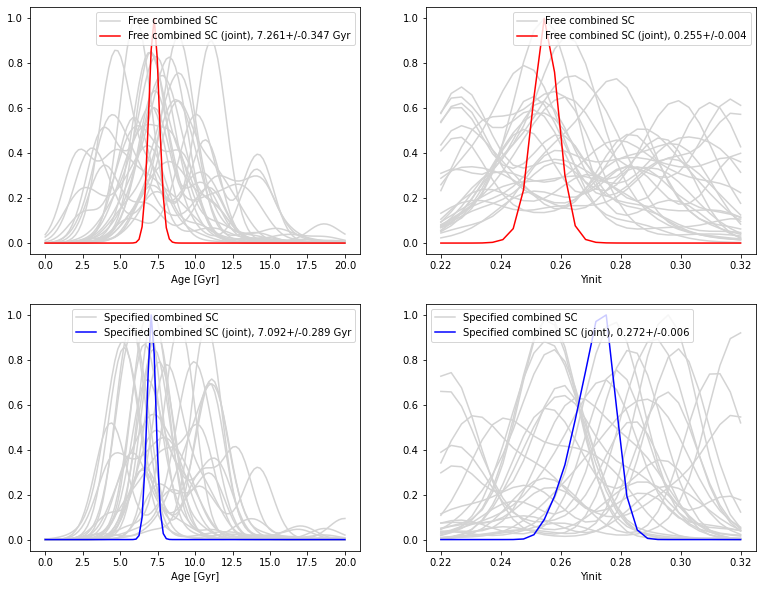

In [39]:
# program
from scipy.optimize import curve_fit

fig, axes = plt.subplots(figsize=(13,10), nrows=2, ncols=2, squeeze=False)
axes = axes.reshape(-1)

joint_prob_t1 = np.ones(len(t))
joint_prob_Y1 = np.ones(len(Y))
for istar in range(Nstar):
    joint_prob_t1 *= prob_t1[istar]
    joint_prob_Y1 *= prob_Y1[istar]

    if istar==0:
        axes[0].plot(t/1e9, prob_t1[istar]/np.max(prob_t1), color='lightgray', label='Free combined SC')
        axes[1].plot(Y, prob_Y1[istar]/np.max(prob_Y1), color='lightgray', label='Free combined SC')
    else:
        axes[0].plot(t/1e9, prob_t1[istar]/np.max(prob_t1), color='lightgray')
        axes[1].plot(Y, prob_Y1[istar]/np.max(prob_Y1), color='lightgray')


joint_prob_t2 = np.ones(len(t))
joint_prob_Y2 = np.ones(len(Y))
for istar in range(Nstar):
    joint_prob_t2 *= prob_t2[istar]
    joint_prob_Y2 *= prob_Y2[istar]
    if istar==0:
        axes[2].plot(t/1e9, prob_t2[istar]/np.max(prob_t2), color='lightgray', label='Specified combined SC')
        axes[3].plot(Y, prob_Y2[istar]/np.max(prob_Y2), color='lightgray', label='Specified combined SC')
    else:
        axes[2].plot(t/1e9, prob_t2[istar]/np.max(prob_t2), color='lightgray')
        axes[3].plot(Y, prob_Y2[istar]/np.max(prob_Y2), color='lightgray')

def gauss_function(x, a, x0, sigma):
    return a*np.exp(-(x-x0)**2/(2*sigma**2))



popt, pcov = curve_fit(gauss_function, t/1e9, joint_prob_t1/np.max(joint_prob_t1), p0=[1., t[np.argmax(joint_prob_t1)]/1e9, 0.07])
axes[0].plot(t/1e9, joint_prob_t1/np.max(joint_prob_t1), color='red', label='Free combined SC (joint), {:0.3f}+/-{:0.3f} Gyr'.format(popt[1], np.abs(popt[2])))

popt, pcov = curve_fit(gauss_function, Y, joint_prob_Y1/np.max(joint_prob_Y1), p0=[1., Y[np.argmax(joint_prob_Y1)], 0.01])
axes[1].plot(Y, joint_prob_Y1/np.max(joint_prob_Y1), color='red', label='Free combined SC (joint), {:0.3f}+/-{:0.3f}'.format(popt[1], np.abs(popt[2])))

popt, pcov = curve_fit(gauss_function, t/1e9, joint_prob_t2/np.max(joint_prob_t2), p0=[1., t[np.argmax(joint_prob_t2)]/1e9, 0.07])
axes[2].plot(t/1e9, joint_prob_t2/np.max(joint_prob_t2), color='blue', label='Specified combined SC (joint), {:0.3f}+/-{:0.3f} Gyr'.format(popt[1], np.abs(popt[2])))

popt, pcov = curve_fit(gauss_function, Y, joint_prob_Y2/np.max(joint_prob_Y2), p0=[1., Y[np.argmax(joint_prob_Y2)], 0.01])
axes[3].plot(Y, joint_prob_Y2/np.max(joint_prob_Y2), color='blue', label='Specified combined SC (joint), {:0.3f}+/-{:0.3f}'.format(popt[1], np.abs(popt[2])))

# axes[0].plot(t/1e9, joint_prob_t2/np.max(joint_prob_t2), color='blue', label='Specified cubic SC')
# axes[1].plot(Y, joint_prob_Y2/np.max(joint_prob_Y2), color='blue', label='Specified cubic SC')
# axes[2].plot(t/1e9, joint_prob_t1/np.max(joint_prob_t1), color='red', label='Free cubic SC')
# axes[3].plot(Y, joint_prob_Y1/np.max(joint_prob_Y1), color='red', label='Free cubic SC')

axes[0].legend()
axes[1].legend()
axes[2].legend()
axes[3].legend()

axes[0].set_xlabel('Age [Gyr]')
axes[1].set_xlabel('Yinit')
axes[2].set_xlabel('Age [Gyr]')
axes[3].set_xlabel('Yinit')


In [151]:
from IPython.display import Image

# Image(filename=rootpath+'hpc/results_sc_combined_linear/002569360/echelle_top10_prob_seismic.png') 
# Image(filename=rootpath+'hpc/results_sc_combined_linear/002437507/echelle_top10_prob_seismic.png') 
# Image(filename=rootpath+'hpc/results_sc_combined_linear/002436332/echelle_top10_prob_seismic.png') 

##  NGC6819

### histogram on age, Y and amlt

In [146]:
idx = np.isin(stars['names'], ['ngc6819']) & (stars['ruwe']<1.2) #ngc6
sample = stars.loc[idx,:].reset_index(drop=True)

In [147]:
sample

,index,KIC,ifsplitting,ifmodelling,ifsupressed,comments,stage,names,_RA,_DE,...,e_g_combined_linear,density_combined_linear,e_density_combined_linear,scaling_logg_fdnu,scaling_radius_fdnu,scaling_mass_fdnu,scaling_lum_fdnu,e_scaling_mass_fdnu,e_scaling_radius_fdnu,e_scaling_lum_fdnu
0,1314,4937576,NaN,1,NaN,NaN,rgb,ngc6819,295.43445,40.09798,...,0.000397,0.000743,0.000036,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1315,5023732,NaN,1,NaN,NaN,rgb,ngc6819,295.20013,40.13569,...,0.000551,0.000567,0.000045,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1316,5023845,NaN,1,NaN,NaN,rgb,ngc6819,295.22308,40.16733,...,0.000954,0.004524,0.000160,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1317,5023931,NaN,1,NaN,NaN,rgb,ngc6819,295.23767,40.16856,...,0.001576,0.001395,0.000172,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1318,5024143,NaN,1,NaN,NaN,rgb,ngc6819,295.27590,40.18147,...,0.001285,0.005237,0.000210,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,1319,5024240,NaN,1,NaN,NaN,rgb,ngc6819,295.29144,40.15156,...,0.003018,0.008278,0.000616,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,1320,5024297,NaN,1,NaN,NaN,rgb,ngc6819,295.30103,40.19274,...,0.001087,0.001229,0.000115,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,1321,5024312,NaN,1,NaN,NaN,rgb,ngc6819,295.30340,40.19150,...,0.000895,0.003824,0.000140,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,1322,5024404,NaN,1,NaN,NaN,rgb,ngc6819,295.31520,40.16959,...,0.001597,0.001309,0.000166,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,1323,5024405,NaN,1,NaN,NaN,rgb,ngc6819,295.31564,40.19332,...,0.003806,0.003908,0.000584,NaN,NaN,NaN,NaN,NaN,NaN,NaN


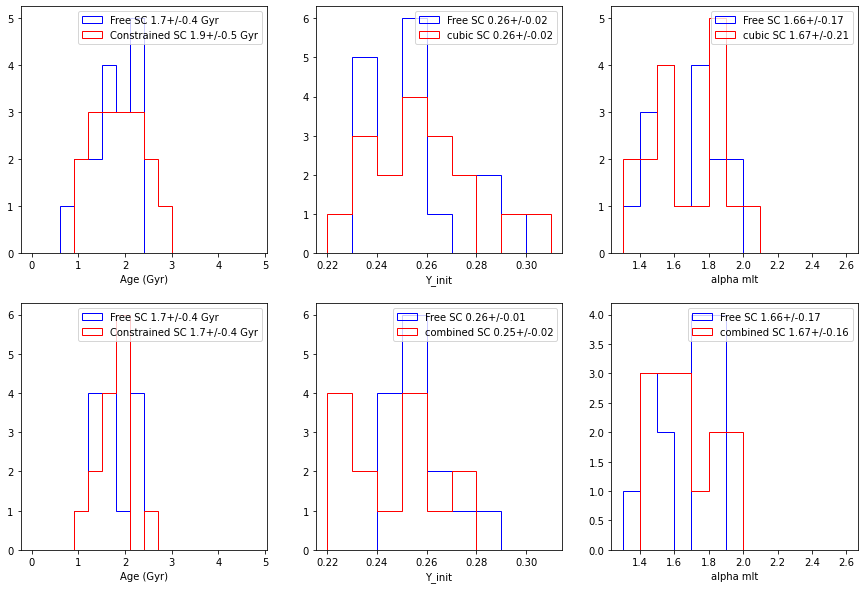

In [149]:
fig, axes = plt.subplots(figsize=(15,10), nrows=2, ncols=3, squeeze=False)
# axes=axes.reshape(-1)

suffixes = ['cubic', 'combined']

for i in range(2):
    suf = suffixes[i]
    
    idx = ((sample['age_{:s}'.format(suf)]/1e9) <18) & ((sample['e_age_{:s}'.format(suf)]/sample['age_{:s}'.format(suf)])<0.5) \
         &((sample['age_{:s}_linear'.format(suf)]/1e9) <18) & ((sample['e_age_{:s}_linear'.format(suf)]/sample['age_{:s}_linear'.format(suf)])<0.5)  # 
    bin_age=np.arange(0,5e9/1e9,0.3)
    hist1 = {"bins":bin_age,"histtype":"step","color":'b',"label":"Free SC {:0.1f}+/-{:0.1f} Gyr".format(np.mean(sample.loc[idx,'age_{:s}'.format(suf)]/1e9), np.std(sample.loc[idx,'age_{:s}'.format(suf)]/1e9))}
    hist2 = {"bins":bin_age,"histtype":"step","color":'r',"label":"Constrained SC {:0.1f}+/-{:0.1f} Gyr".format(np.mean(sample.loc[idx,'age_{:s}_linear'.format(suf)]/1e9), np.std(sample.loc[idx,'age_{:s}_linear'.format(suf)]/1e9))}
    axes[i,0].hist(sample.loc[idx,'age_{:s}'.format(suf)]/1e9, **hist1)
    axes[i,0].hist(sample.loc[idx,'age_{:s}_linear'.format(suf)]/1e9, **hist2)

    bin_yinit=np.arange(0.22, 0.32, 0.01)
    hist1 = {"bins":bin_yinit,"histtype":"step","color":'b',"label":"Free SC {:0.2f}+/-{:0.2f}".format(np.mean(sample.loc[idx,'Yinit_{:s}'.format(suf)]), np.std(sample.loc[idx,'Yinit_{:s}'.format(suf)]))}
    hist2 = {"bins":bin_yinit,"histtype":"step","color":'r',"label":"{:s} SC {:0.2f}+/-{:0.2f}".format(suf, np.mean(sample.loc[idx,'Yinit_{:s}_linear'.format(suf)]), np.std(sample.loc[idx,'Yinit_{:s}_linear'.format(suf)]))}
    axes[i,1].hist(sample.loc[idx,'Yinit_{:s}'.format(suf)], **hist1)
    axes[i,1].hist(sample.loc[idx,'Yinit_{:s}_linear'.format(suf)], **hist2)

    bin_amlt=np.arange(1.3, 2.7, 0.1)
    hist1 = {"bins":bin_amlt,"histtype":"step","color":'b',"label":"Free SC {:0.2f}+/-{:0.2f}".format(np.mean(sample.loc[idx,'amlt_{:s}'.format(suf)]), np.std(sample.loc[idx,'amlt_{:s}'.format(suf)]))}
    hist2 = {"bins":bin_amlt,"histtype":"step","color":'r',"label":"{:s} SC {:0.2f}+/-{:0.2f}".format(suf, np.mean(sample.loc[idx,'amlt_{:s}_linear'.format(suf)]), np.std(sample.loc[idx,'amlt_{:s}_linear'.format(suf)]))}
    axes[i,2].hist(sample.loc[idx,'amlt_{:s}'.format(suf)], **hist1)
    axes[i,2].hist(sample.loc[idx,'amlt_{:s}_linear'.format(suf)], **hist2)
    
    axes[i,0].set_xlabel('Age (Gyr)')
    axes[i,1].set_xlabel('Y_init')
    axes[i,2].set_xlabel('alpha mlt')

    axes[i,0].legend()
    axes[i,1].legend()
    axes[i,2].legend()
    

### KDE on age
#### cubic

In [22]:
idx = np.isin(stars['names'], ['ngc6819']) & (stars['ruwe']<1.2)#ngc6
sample = stars.loc[idx,:].reset_index(drop=True)

In [23]:
probs1, Yinits1, ages1 = [[] for i in range(3)]
probs2, Yinits2, ages2 = [[] for i in range(3)]
for istar, star in sample.loc[:,:].iterrows():
    
    cols = ['prob', 'Yinit', 'star_age']
    
    data = h5py.File(work_dir+'../hpc/results_cubic/{:09.0f}/data.h5'.format(star['KIC']), 'r')
    prob, Yinit, age = [data[col][:] for col in cols]
    
    probs1.append(prob)
    Yinits1.append(Yinit)
    ages1.append(age)

    data = h5py.File(work_dir+'../hpc/results_sc_cubic_linear/{:09.0f}/data.h5'.format(star['KIC']), 'r')
    prob, Yinit, age = [data[col][:] for col in cols]
    
    probs2.append(prob)
    Yinits2.append(Yinit)
    ages2.append(age)

In [24]:
Nstar = len(probs1)
# Y_bins = np.linspace(0.25, 0.30, 11)
# t_bins = np.linspace(0,20e9,20) #/1e9

t = np.linspace(0,5e9,100)
prob_t1 = [np.zeros(len(t)) for i in range(Nstar)]
prob_t2 = [np.zeros(len(t)) for i in range(Nstar)]

Y = np.linspace(0.22,0.32,30)
prob_Y1 = [np.zeros(len(Y)) for i in range(Nstar)]
prob_Y2 = [np.zeros(len(Y)) for i in range(Nstar)]

from sklearn.neighbors import KernelDensity

for istar in range(Nstar):
    idx = (probs1[istar]>0) #& (Yinits1[istar]>0.23) & (Yinits1[istar]<0.28)
    
    kde = KernelDensity(kernel='gaussian', bandwidth=0.2e9).fit(ages1[istar][idx][:,None], None, probs1[istar][idx])
    prob_t1[istar] = np.exp(kde.score_samples(t[:, None]))
    
    kde = KernelDensity(kernel='gaussian', bandwidth=0.01).fit(Yinits1[istar][idx][:,None], None, probs1[istar][idx])
    prob_Y1[istar] = np.exp(kde.score_samples(Y[:, None]))

    idx = (probs2[istar]>0) #& (Yinits2[istar]>0.23) & (Yinits2[istar]<0.28)
    
    kde = KernelDensity(kernel='gaussian', bandwidth=0.2e9).fit(ages2[istar][idx][:,None], None, probs2[istar][idx])
    prob_t2[istar] = np.exp(kde.score_samples(t[:, None]))
    
    kde = KernelDensity(kernel='gaussian', bandwidth=0.01).fit(Yinits2[istar][idx][:,None], None, probs2[istar][idx])
    prob_Y2[istar] = np.exp(kde.score_samples(Y[:, None]))

Text(0.5, 0, 'Yinit')

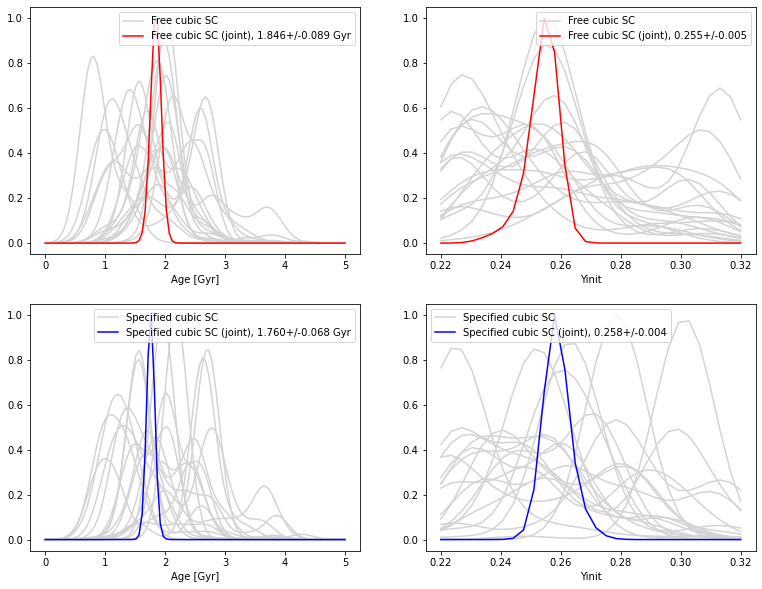

In [25]:
# program
from scipy.optimize import curve_fit

fig, axes = plt.subplots(figsize=(13,10), nrows=2, ncols=2, squeeze=False)
axes = axes.reshape(-1)

joint_prob_t1 = np.ones(len(t))
joint_prob_Y1 = np.ones(len(Y))
for istar in range(Nstar):
    joint_prob_t1 *= prob_t1[istar]
    joint_prob_Y1 *= prob_Y1[istar]

    if istar==0:
        axes[0].plot(t/1e9, prob_t1[istar]/np.max(prob_t1), color='lightgray', label='Free cubic SC')
        axes[1].plot(Y, prob_Y1[istar]/np.max(prob_Y1), color='lightgray', label='Free cubic SC')
    else:
        axes[0].plot(t/1e9, prob_t1[istar]/np.max(prob_t1), color='lightgray')
        axes[1].plot(Y, prob_Y1[istar]/np.max(prob_Y1), color='lightgray')


joint_prob_t2 = np.ones(len(t))
joint_prob_Y2 = np.ones(len(Y))
for istar in range(Nstar):
    joint_prob_t2 *= prob_t2[istar]
    joint_prob_Y2 *= prob_Y2[istar]
    if istar==0:
        axes[2].plot(t/1e9, prob_t2[istar]/np.max(prob_t2), color='lightgray', label='Specified cubic SC')
        axes[3].plot(Y, prob_Y2[istar]/np.max(prob_Y2), color='lightgray', label='Specified cubic SC')
    else:
        axes[2].plot(t/1e9, prob_t2[istar]/np.max(prob_t2), color='lightgray')
        axes[3].plot(Y, prob_Y2[istar]/np.max(prob_Y2), color='lightgray')

def gauss_function(x, a, x0, sigma):
    return a*np.exp(-(x-x0)**2/(2*sigma**2))



popt, pcov = curve_fit(gauss_function, t/1e9, joint_prob_t1/np.max(joint_prob_t1), p0=[1., t[np.argmax(joint_prob_t1)]/1e9, 0.07])
axes[0].plot(t/1e9, joint_prob_t1/np.max(joint_prob_t1), color='red', label='Free cubic SC (joint), {:0.3f}+/-{:0.3f} Gyr'.format(popt[1], np.abs(popt[2])))

popt, pcov = curve_fit(gauss_function, Y, joint_prob_Y1/np.max(joint_prob_Y1), p0=[1., Y[np.argmax(joint_prob_Y1)], 0.01])
axes[1].plot(Y, joint_prob_Y1/np.max(joint_prob_Y1), color='red', label='Free cubic SC (joint), {:0.3f}+/-{:0.3f}'.format(popt[1], np.abs(popt[2])))

popt, pcov = curve_fit(gauss_function, t/1e9, joint_prob_t2/np.max(joint_prob_t2), p0=[1., t[np.argmax(joint_prob_t2)]/1e9, 0.07])
axes[2].plot(t/1e9, joint_prob_t2/np.max(joint_prob_t2), color='blue', label='Specified cubic SC (joint), {:0.3f}+/-{:0.3f} Gyr'.format(popt[1], np.abs(popt[2])))

popt, pcov = curve_fit(gauss_function, Y, joint_prob_Y2/np.max(joint_prob_Y2), p0=[1., Y[np.argmax(joint_prob_Y2)], 0.01])
axes[3].plot(Y, joint_prob_Y2/np.max(joint_prob_Y2), color='blue', label='Specified cubic SC (joint), {:0.3f}+/-{:0.3f}'.format(popt[1], np.abs(popt[2])))

# axes[0].plot(t/1e9, joint_prob_t2/np.max(joint_prob_t2), color='blue', label='Specified cubic SC')
# axes[1].plot(Y, joint_prob_Y2/np.max(joint_prob_Y2), color='blue', label='Specified cubic SC')
# axes[2].plot(t/1e9, joint_prob_t1/np.max(joint_prob_t1), color='red', label='Free cubic SC')
# axes[3].plot(Y, joint_prob_Y1/np.max(joint_prob_Y1), color='red', label='Free cubic SC')

axes[0].legend()
axes[1].legend()
axes[2].legend()
axes[3].legend()

axes[0].set_xlabel('Age [Gyr]')
axes[1].set_xlabel('Yinit')
axes[2].set_xlabel('Age [Gyr]')
axes[3].set_xlabel('Yinit')


#### combined

In [26]:
idx = np.isin(stars['names'], ['ngc6819']) & (stars['ruwe']<1.2)#ngc6
sample = stars.loc[idx,:].reset_index(drop=True)

In [27]:
probs1, Yinits1, ages1 = [[] for i in range(3)]
probs2, Yinits2, ages2 = [[] for i in range(3)]
for istar, star in sample.loc[:,:].iterrows():
    
    cols = ['prob', 'Yinit', 'star_age']
    
    data = h5py.File(work_dir+'../hpc/results_combined/{:09.0f}/data.h5'.format(star['KIC']), 'r')
    prob, Yinit, age = [data[col][:] for col in cols]
    
    probs1.append(prob)
    Yinits1.append(Yinit)
    ages1.append(age)

    data = h5py.File(work_dir+'../hpc/results_sc_combined_linear/{:09.0f}/data.h5'.format(star['KIC']), 'r')
    prob, Yinit, age = [data[col][:] for col in cols]
    
    probs2.append(prob)
    Yinits2.append(Yinit)
    ages2.append(age)

In [28]:
Nstar = len(probs1)
# Y_bins = np.linspace(0.25, 0.30, 11)
# t_bins = np.linspace(0,20e9,20) #/1e9

t = np.linspace(0,5e9,100)
prob_t1 = [np.zeros(len(t)) for i in range(Nstar)]
prob_t2 = [np.zeros(len(t)) for i in range(Nstar)]

Y = np.linspace(0.22,0.32,30)
prob_Y1 = [np.zeros(len(Y)) for i in range(Nstar)]
prob_Y2 = [np.zeros(len(Y)) for i in range(Nstar)]

from sklearn.neighbors import KernelDensity

for istar in range(Nstar):
    idx = (probs1[istar]>0) #& (Yinits1[istar]>0.23) & (Yinits1[istar]<0.28)
    
    kde = KernelDensity(kernel='gaussian', bandwidth=0.2e9).fit(ages1[istar][idx][:,None], None, probs1[istar][idx])
    prob_t1[istar] = np.exp(kde.score_samples(t[:, None]))
    
    kde = KernelDensity(kernel='gaussian', bandwidth=0.01).fit(Yinits1[istar][idx][:,None], None, probs1[istar][idx])
    prob_Y1[istar] = np.exp(kde.score_samples(Y[:, None]))

    idx = (probs2[istar]>0) #& (Yinits2[istar]>0.23) & (Yinits2[istar]<0.28)
    
    kde = KernelDensity(kernel='gaussian', bandwidth=0.2e9).fit(ages2[istar][idx][:,None], None, probs2[istar][idx])
    prob_t2[istar] = np.exp(kde.score_samples(t[:, None]))
    
    kde = KernelDensity(kernel='gaussian', bandwidth=0.01).fit(Yinits2[istar][idx][:,None], None, probs2[istar][idx])
    prob_Y2[istar] = np.exp(kde.score_samples(Y[:, None]))

Text(0.5, 0, 'Yinit')

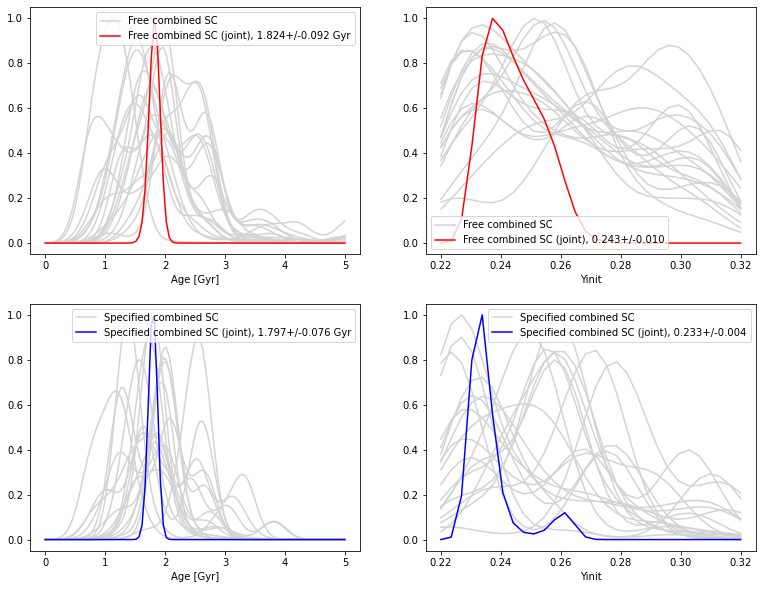

In [29]:
# program
from scipy.optimize import curve_fit

fig, axes = plt.subplots(figsize=(13,10), nrows=2, ncols=2, squeeze=False)
axes = axes.reshape(-1)

joint_prob_t1 = np.ones(len(t))
joint_prob_Y1 = np.ones(len(Y))
for istar in range(Nstar):
    joint_prob_t1 *= prob_t1[istar]
    joint_prob_Y1 *= prob_Y1[istar]

    if istar==0:
        axes[0].plot(t/1e9, prob_t1[istar]/np.max(prob_t1), color='lightgray', label='Free combined SC')
        axes[1].plot(Y, prob_Y1[istar]/np.max(prob_Y1), color='lightgray', label='Free combined SC')
    else:
        axes[0].plot(t/1e9, prob_t1[istar]/np.max(prob_t1), color='lightgray')
        axes[1].plot(Y, prob_Y1[istar]/np.max(prob_Y1), color='lightgray')


joint_prob_t2 = np.ones(len(t))
joint_prob_Y2 = np.ones(len(Y))
for istar in range(Nstar):
    joint_prob_t2 *= prob_t2[istar]
    joint_prob_Y2 *= prob_Y2[istar]
    if istar==0:
        axes[2].plot(t/1e9, prob_t2[istar]/np.max(prob_t2), color='lightgray', label='Specified combined SC')
        axes[3].plot(Y, prob_Y2[istar]/np.max(prob_Y2), color='lightgray', label='Specified combined SC')
    else:
        axes[2].plot(t/1e9, prob_t2[istar]/np.max(prob_t2), color='lightgray')
        axes[3].plot(Y, prob_Y2[istar]/np.max(prob_Y2), color='lightgray')

def gauss_function(x, a, x0, sigma):
    return a*np.exp(-(x-x0)**2/(2*sigma**2))



popt, pcov = curve_fit(gauss_function, t/1e9, joint_prob_t1/np.max(joint_prob_t1), p0=[1., t[np.argmax(joint_prob_t1)]/1e9, 0.07])
axes[0].plot(t/1e9, joint_prob_t1/np.max(joint_prob_t1), color='red', label='Free combined SC (joint), {:0.3f}+/-{:0.3f} Gyr'.format(popt[1], np.abs(popt[2])))

popt, pcov = curve_fit(gauss_function, Y, joint_prob_Y1/np.max(joint_prob_Y1), p0=[1., Y[np.argmax(joint_prob_Y1)], 0.01])
axes[1].plot(Y, joint_prob_Y1/np.max(joint_prob_Y1), color='red', label='Free combined SC (joint), {:0.3f}+/-{:0.3f}'.format(popt[1], np.abs(popt[2])))

popt, pcov = curve_fit(gauss_function, t/1e9, joint_prob_t2/np.max(joint_prob_t2), p0=[1., t[np.argmax(joint_prob_t2)]/1e9, 0.07])
axes[2].plot(t/1e9, joint_prob_t2/np.max(joint_prob_t2), color='blue', label='Specified combined SC (joint), {:0.3f}+/-{:0.3f} Gyr'.format(popt[1], np.abs(popt[2])))

popt, pcov = curve_fit(gauss_function, Y, joint_prob_Y2/np.max(joint_prob_Y2), p0=[1., Y[np.argmax(joint_prob_Y2)], 0.01])
axes[3].plot(Y, joint_prob_Y2/np.max(joint_prob_Y2), color='blue', label='Specified combined SC (joint), {:0.3f}+/-{:0.3f}'.format(popt[1], np.abs(popt[2])))

# axes[0].plot(t/1e9, joint_prob_t2/np.max(joint_prob_t2), color='blue', label='Specified cubic SC')
# axes[1].plot(Y, joint_prob_Y2/np.max(joint_prob_Y2), color='blue', label='Specified cubic SC')
# axes[2].plot(t/1e9, joint_prob_t1/np.max(joint_prob_t1), color='red', label='Free cubic SC')
# axes[3].plot(Y, joint_prob_Y1/np.max(joint_prob_Y1), color='red', label='Free cubic SC')

axes[0].legend()
axes[1].legend()
axes[2].legend()
axes[3].legend()

axes[0].set_xlabel('Age [Gyr]')
axes[1].set_xlabel('Yinit')
axes[2].set_xlabel('Age [Gyr]')
axes[3].set_xlabel('Yinit')


# Outliers in luminosity (parallax)
- Compare modelling w/ Lum constraint and wo/ Lum constraint. Are the outliers (in the numax/Dnu plot) present in the former method still present in the latter?
- If the latter does still have outliers, does applying the recipe improve?


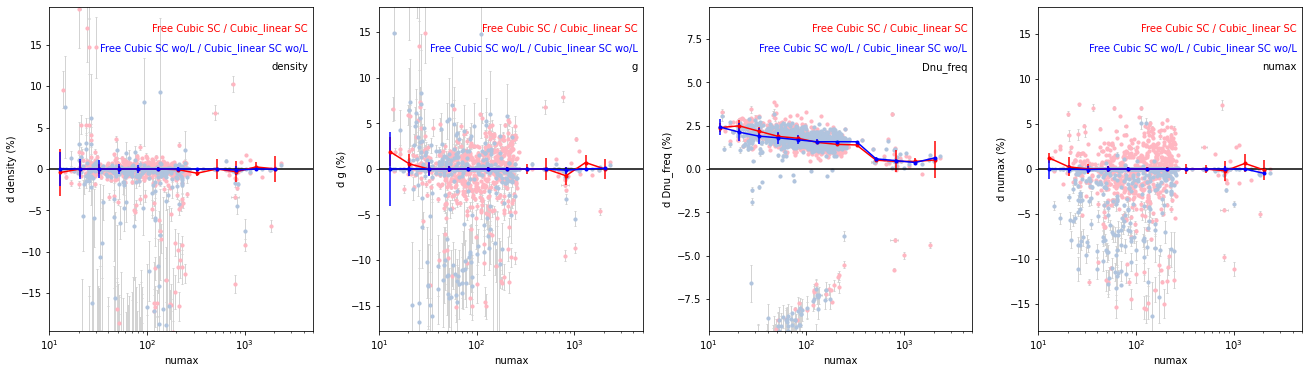

In [47]:
import matplotlib.colors
norm = matplotlib.colors.Normalize(vmin=-0.5,vmax=0.5)

gridspec_kw = {'left':0.07, 'right':0.94, 'top':0.96, 'bottom':0.06, 'wspace':0.25, 'hspace':0.25}
fig, axes = plt.subplots(figsize=(20,5), nrows=1, ncols=4, squeeze=False, gridspec_kw=gridspec_kw)
axes = axes.reshape(-1)

errorstyle = {'elinewidth':1, 'capsize':1, 'ecolor':'lightgray', 'linestyle':'None', 'zorder':-10}

var = ['density', 'g', 'Dnu_freq', 'numax']


for iax, ax in enumerate(axes[:]):
    v1 = var[iax]+'_cubic'
    ev1 = 'e_'+var[iax]+'_cubic'

    v2 = var[iax]+'_cubic_linear'
    ev2 = 'e_'+var[iax]+'_cubic_linear'
    
    
    v3 = var[iax]+'_cubic_wo_L'
    ev3 = 'e_'+var[iax]+'_cubic_wo_L'

    v4 = var[iax]+'_cubic_linear_wo_L'
    ev4 = 'e_'+var[iax]+'_cubic_linear_wo_L'

    
    x = sample.loc[:,'numax']
    y1 = (sample.loc[:,v1]/sample.loc[:,v2]-1)*100
    y2 = (sample.loc[:,v3]/sample.loc[:,v4]-1)*100
    
    ex = sample.loc[:,'e_numax']
    ey1 = y1*((sample.loc[:,ev1]/sample.loc[:,v1])**2.0 + (sample.loc[:,ev2]/sample.loc[:,v2])**2.0)**0.5
    ey2 = y2*((sample.loc[:,ev3]/sample.loc[:,v4])**2.0 + (sample.loc[:,ev3]/sample.loc[:,v3])**2.0)**0.5
    
    idx = np.isfinite(x) & np.isfinite(y1) & np.isfinite(ex) & np.isfinite(ey1) & np.isfinite(y2) & np.isfinite(ey2)
    x,y1,ex,ey1 = x[idx],y1[idx],ex[idx],ey1[idx]
    y2,ey2 = y2[idx],ey2[idx]
    
    xcs1, medians1, stds1 = se.get_binned_median(x, y1, np.logspace(np.log(10), np.log(4000), 14, base=np.e))
    xcs2, medians2, stds2 = se.get_binned_median(x, y2, np.logspace(np.log(10), np.log(4000), 14, base=np.e))
    
    ax.scatter(x, y1, color='lightpink', marker='o', s=10)
    ax.scatter(x, y2, color='lightsteelblue', marker='o', s=10)
    ax.errorbar(x, y1, xerr=ex, yerr=ey1, **errorstyle)
    ax.errorbar(x, y2, xerr=ex, yerr=ey2, **errorstyle)
    ax.errorbar(xcs1, medians1, yerr=stds1, fmt='r.-')
    ax.errorbar(xcs2, medians2, yerr=stds2, fmt='b.-')
    
    ax.set_xlim(10, 5000)
    ax.set_ylim(-np.std(y1)*5, np.std(y1)*5)
    ax.set_xlabel('numax')
    ax.set_xscale('log')
    ax.axhline(0., linestyle='-', color='k')
    ax.set_ylabel('d {:s} (%)'.format(var[iax]))
    ax.text(0.98, 0.95, 'Free Cubic SC / Cubic_linear SC', transform=ax.transAxes, ha='right', va='top', color='r')
    ax.text(0.98, 0.89, 'Free Cubic SC wo/L / Cubic_linear SC wo/L', transform=ax.transAxes, ha='right', va='top', color='b')
    ax.text(0.98, 0.83, var[iax], transform=ax.transAxes, ha='right', va='top', color='k')

In [79]:
Teff_sun = 5777.0
numax_sun = 3090.0
Dnu_sun = 135.1
g_sun = 10.0**4.43796037457

from fdnu import asfgrid

idx = (stars['ifmodelling']==1) 

feh = np.array(stars.loc[idx,'[M/H]'])
Teff = np.array(stars.loc[idx,'Teff'])
e_Teff = np.array(stars.loc[idx,'e_Teff'])
Dnu = np.array(stars.loc[idx,'Dnu'])
e_Dnu = np.array(stars.loc[idx,'e_Dnu'])
numax = np.array(stars.loc[idx,'numax'])
e_numax = np.array(stars.loc[idx,'e_numax'])
evstate=np.zeros((stars.loc[idx,"Dnu"].shape[0],))+1
s=asfgrid.Seism(datadir=rootpath+"fdnu/")
mass_fdnu, radius_fdnu = s.get_mass_radius(evstate,feh,Teff,Dnu,numax,fill_value='linear',isfeh=True)
lum_fdnu =  (radius_fdnu)**2. *(Teff/Teff_sun)**4.
stars.loc[idx,'scaling_logg_fdnu'] = np.log10(mass_fdnu/radius_fdnu**2. * g_sun)
stars.loc[idx,'scaling_radius_fdnu'] = radius_fdnu
stars.loc[idx,'scaling_mass_fdnu'] = mass_fdnu
stars.loc[idx,'scaling_lum_fdnu'] = lum_fdnu

stars.loc[idx,'e_scaling_mass_fdnu'] = ((3*e_numax/numax)**2. + \
                            (4*e_Dnu/Dnu)**2. + \
                            (1.5*e_Teff/Teff)**2.)**0.5 * mass_fdnu
stars.loc[idx,'e_scaling_radius_fdnu'] = ((1*e_numax/numax)**2. + \
                            (2*e_Dnu/Dnu)**2. + \
                            (0.5*e_Teff/Teff)**2.)**0.5 * radius_fdnu
stars.loc[idx,'e_scaling_lum_fdnu'] = ((2*stars.loc[idx,'e_scaling_radius_fdnu']/radius_fdnu)**2. + \
                            (4*e_Teff/Teff)**2.)**0.5 * lum_fdnu

[[('logz', 'float64', ()), ('mass', 'float64', ()), ('evstate', 'float64', ()), ('logg_teff', 'float64', ()), ('logg', 'float64', ()), ('teff', 'float64', ()), ('fdnu', 'float64', ()), ('fdnu_int', 'float64', ()), ('mass_nu', 'float64', ()), ('age', 'float64', ()), ('dp', 'float64', ()), ('central_he4', 'float64', ()), ('model', 'int64', ())], [b'NULL', b'NULL', b'NULL', b'NULL', b'NULL', b'NULL', b'NULL', b'NULL', b'NULL', b'NULL', b'NULL', b'NULL', b'NULL']]
[[('logz', 'float64', ()), ('mass', 'float64', ()), ('evstate', 'float64', ()), ('logg_teff', 'float64', ()), ('logg', 'float64', ()), ('teff', 'float64', ()), ('fdnu', 'float64', ()), ('fdnu_int', 'float64', ()), ('mass_nu', 'float64', ()), ('age', 'float64', ()), ('dp', 'float64', ()), ('central_he4', 'float64', ()), ('model', 'int64', ())], [b'NULL', b'NULL', b'NULL', b'NULL', b'NULL', b'NULL', b'NULL', b'NULL', b'NULL', b'NULL', b'NULL', b'NULL', b'NULL']]


Text(0.5, 0, '(L_seis/L_Gaia - 1) / sigma')

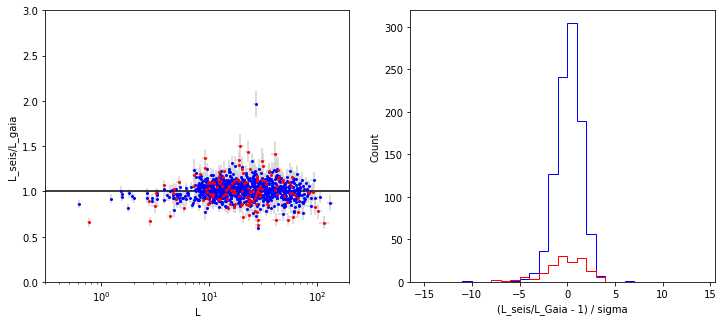

In [123]:
fig, axes = plt.subplots(figsize=[12,5], nrows=1, ncols=2, squeeze=True)

sample = stars.copy()

idx1 = ((sample['e_lum_J']/sample['lum_J']) < 0.1) \
        & ((sample['e_scaling_lum_fdnu']/sample['scaling_lum_fdnu']) < 0.1) \
        & (sample['ruwe']<1.2)
idx2 = ((sample['e_lum_J']/sample['lum_J']) < 0.1) \
        & ((sample['e_scaling_lum_fdnu']/sample['scaling_lum_fdnu']) < 0.1) \
        & (sample['ruwe']>1.2)

sample['lum_fdiff'] = sample['scaling_lum_fdnu']/sample['lum_J']
sample['e_lum_fdiff'] = ((sample['e_scaling_lum_fdnu']/sample['scaling_lum_fdnu'])**2.0 \
               +(sample['e_lum_J']/sample['lum_J'])**2.0)**0.5 * (sample['scaling_lum_fdnu']/sample['lum_J'])

axes[0].errorbar(sample.loc[idx1,'lum_J'], sample.loc[idx1,'lum_fdiff'], 
            xerr = sample.loc[idx1,'e_lum_J'], 
            yerr = sample.loc[idx1,'e_lum_fdiff'],
            ecolor='lightgray', linestyle='none', marker='.', mfc='blue', mec='none')
axes[0].errorbar(sample.loc[idx2,'lum_J'], sample.loc[idx2,'lum_fdiff'], 
            xerr = sample.loc[idx2,'e_lum_J'], 
            yerr = sample.loc[idx2,'e_lum_fdiff'],
            ecolor='lightgray', linestyle='none', marker='.', mfc='red', mec='none')
axes[0].set_xscale('log')
axes[0].set_xlim(0.3, 200)
axes[0].set_ylim(0., 3.0)
axes[0].axhline(1.0, linestyle='-', color='k')
axes[0].set_xlabel('L')
axes[0].set_ylabel('L_seis/L_gaia')

axes[1].hist((sample.loc[idx1,'lum_fdiff']-1)/sample.loc[idx1,'e_lum_fdiff'], bins=np.arange(-15,15,1), color='blue', histtype='step')
axes[1].hist((sample.loc[idx2,'lum_fdiff']-1)/sample.loc[idx2,'e_lum_fdiff'], bins=np.arange(-15,15,1), color='red', histtype='step')
axes[1].set_ylabel('Count')
axes[1].set_xlabel('(L_seis/L_Gaia - 1) / sigma')

,index,KIC,ifsplitting,ifmodelling,ifsupressed,comments,stage,names,_RA,_DE,...,e_g_combined_linear,density_combined_linear,e_density_combined_linear,scaling_logg_fdnu,scaling_radius_fdnu,scaling_mass_fdnu,scaling_lum_fdnu,e_scaling_mass_fdnu,e_scaling_radius_fdnu,e_scaling_lum_fdnu
0,0,1,NaN,1,0.0,NaN,esg,mu Her,266.61469,27.720621,...,0.007745,0.220084,0.005339,4.024622,1.779520,1.222551,2.717037,0.049201,0.025262,0.210141
1,1,2991448,-1.0,1,0.0,NaN,esg,NaN,291.82490,38.113190,...,0.001668,0.202850,0.001090,3.980089,1.745969,1.062188,2.668634,0.025579,0.014160,0.076469
2,3,4346201,-1.0,1,0.0,NaN,esg,NaN,285.28595,39.498050,...,0.008847,0.168455,0.005767,3.958615,1.952204,1.263879,4.487968,0.107110,0.056574,0.298375
3,5,5607242,1.0,1,0.0,NaN,esg,NaN,287.64633,40.843060,...,0.010729,0.088683,0.005338,3.765729,2.462783,1.290093,4.807814,0.026963,0.019013,0.194641
4,6,5689820,1.0,1,0.0,NaN,esg,NaN,286.22723,40.927730,...,0.005663,0.093843,0.002811,3.749812,2.261362,1.048557,2.769848,0.024458,0.018207,0.088128
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1287,1343,8430105,NaN,1,NaN,NaN,rgb,binary,291.55862,44.488190,...,0.001585,0.002966,0.000247,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1288,1344,9153621,NaN,1,NaN,NaN,rgb,binary,291.41193,45.535190,...,0.000982,0.001086,0.000112,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1289,1346,9540226,NaN,1,NaN,NaN,rgb,binary,297.03400,46.198470,...,0.000142,0.000606,0.000012,2.331584,13.800524,1.490783,77.363988,0.225676,0.702676,8.099141
1290,1347,9970396,NaN,1,NaN,NaN,rgb,binary,298.70980,46.833030,...,0.000391,0.002367,0.000058,2.714787,8.563516,1.387173,36.852673,0.213896,0.452613,4.117509


In [ ]:
idx = ((stars['e_lum_J']/stars['lum_J']) < 0.3)
stars.loc[idx,'scaling_lum_fdnu']/stars.loc[idx,'lum_J']

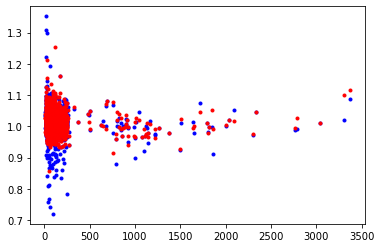

In [132]:
plt.plot(stars['numax'], stars['numax_cubic']/stars['numax'], 'b.')
plt.plot(stars['numax'], stars['numax_cubic_linear']/stars['numax'], 'r.')

# Interferometric radii

Not very helpful

In [38]:
sample = pd.read_csv('marc_RGB_interf_seis.csv')
sample

,hd_id,rad,rad_sig,teff,teff_err,met,met_err,numax,numax_err,dnu,dnu_err,AD,AD_sig,author
0,180610,8.87,0.17,4508.666667,90.173333,0.006667,0.05,54.589062,0.565585,5.42,0.03,1.630,0.028,Baines_2018
1,176408,10.24,0.23,4591.870605,91.837412,0.100440,0.05,42.077602,0.725161,4.28,0.03,1.125,0.023,Baines_2010
2,167042,4.45,0.08,4941.020996,98.820420,0.036222,0.05,249.230000,12.461500,17.17,0.07,0.823,0.011,White_18
3,175305,8.20,0.11,5059.988770,101.199775,-1.363600,0.05,52.199036,0.349423,5.86,0.02,0.484,0.006,Karovicova_2020


In [40]:
from fdnu.asfgrid import Seism

idx = sample.index>=0

Nstar = np.sum(idx)
evstate= np.ones(Nstar)
feh=sample.loc[idx,'met'].to_numpy() #[-1.97,-1.98]
Teff=sample.loc[idx,'teff'].to_numpy() #[4659.8,4903.2]
Dnu=sample.loc[idx,'dnu'].to_numpy() #[8.81,13.1]
numax=sample.loc[idx,'numax'].to_numpy() #[92.36,157.3]
s=Seism(datadir='fdnu/')
mass,radius=s.get_mass_radius(evstate,feh,Teff,Dnu,numax,isfeh=True)
logg=s.mr2logg(mass,radius)
_,_,fDnu=s.get_dnu_numax(evstate,feh,Teff,mass,mass,logg,isfeh=True)

sample.loc[idx,'fDnu_S16'] = fDnu

numax_sun = 3090
Teff_sun = 5777
Dnu_sun = 135.1 

radius = (sample['numax']/numax_sun)**1 * (sample['dnu']/Dnu_sun)**-2. * sample['fDnu_S16']**2.0 * (sample['teff']/Teff_sun)**0.5
e_radius = radius * ((1*sample['numax_err']/sample['numax'])**2. + (2*sample['dnu_err']/sample['dnu'])**2. + (0.5*sample['teff_err']/sample['teff'])**2.)**0.5

sample['Rseis_S16'], sample['e_Rseis_S16'] = radius, e_radius

[[('logz', 'float64', ()), ('mass', 'float64', ()), ('evstate', 'float64', ()), ('logg_teff', 'float64', ()), ('logg', 'float64', ()), ('teff', 'float64', ()), ('fdnu', 'float64', ()), ('fdnu_int', 'float64', ()), ('mass_nu', 'float64', ()), ('age', 'float64', ()), ('dp', 'float64', ()), ('central_he4', 'float64', ()), ('model', 'int64', ())], [b'NULL', b'NULL', b'NULL', b'NULL', b'NULL', b'NULL', b'NULL', b'NULL', b'NULL', b'NULL', b'NULL', b'NULL', b'NULL']]
[[('logz', 'float64', ()), ('mass', 'float64', ()), ('evstate', 'float64', ()), ('logg_teff', 'float64', ()), ('logg', 'float64', ()), ('teff', 'float64', ()), ('fdnu', 'float64', ()), ('fdnu_int', 'float64', ()), ('mass_nu', 'float64', ()), ('age', 'float64', ()), ('dp', 'float64', ()), ('central_he4', 'float64', ()), ('model', 'int64', ())], [b'NULL', b'NULL', b'NULL', b'NULL', b'NULL', b'NULL', b'NULL', b'NULL', b'NULL', b'NULL', b'NULL', b'NULL', b'NULL']]


In [51]:
import scaling

Npart = int(len(sample)/100+1)

for ipart in range(Npart):
    print(ipart)
    idx = (sample.index>=(ipart*100)) & (sample.index<((ipart+1)*100))
    Nstar = np.sum(idx)

    feh, e_feh = sample.loc[idx,'met'].to_numpy(), sample.loc[idx,'met_err'].to_numpy() #[-1.97,-1.98]
    Teff, e_Teff = sample.loc[idx,'teff'].to_numpy(), sample.loc[idx,'teff_err'].to_numpy() #[4659.8,4903.2]
    Dnu, e_Dnu = sample.loc[idx,'dnu'].to_numpy(), sample.loc[idx,'dnu_err'].to_numpy() #[8.81,13.1]
    numax, e_numax = sample.loc[idx,'numax'].to_numpy(), sample.loc[idx,'numax_err'].to_numpy() #[92.36,157.3]

    s = scaling.seismo(path_grid_models='models/mygrid.parquet')
    s.set_observables(Teff=Teff, e_Teff=e_Teff, 
                      MH=feh, e_MH=e_feh,
                      numax=numax, e_numax=e_numax, 
                      Dnu=Dnu, e_Dnu=e_Dnu)

    sample.loc[idx,'fDnu_o'], sample.loc[idx,'e_fDnu_o']  = s._get_estimators('fDnu_o')
    sample.loc[idx,'fDnu'], sample.loc[idx,'e_fDnu']  = s._get_estimators('fDnu')
    sample.loc[idx,'Rseis_m'], sample.loc[idx,'e_Rseis_m'] = s.get_radius()

0


In [52]:
radius = (sample['numax']/numax_sun)**1 * (sample['dnu']/Dnu_sun)**-2. * sample['fDnu_o']**2.0 * (sample['teff']/Teff_sun)**0.5
e_radius = radius * ((1*sample['numax_err']/sample['numax'])**2. + (2*sample['dnu_err']/sample['dnu'])**2. + (0.5*sample['teff_err']/sample['teff'])**2.)**0.5

sample['Rseis_o'], sample['e_Rseis_o'] = radius, e_radius


radius = (sample['numax']/numax_sun)**1 * (sample['dnu']/Dnu_sun)**-2. * sample['fDnu']**2.0 * (sample['teff']/Teff_sun)**0.5
e_radius = radius * ((1*sample['numax_err']/sample['numax'])**2. + (2*sample['dnu_err']/sample['dnu'])**2. + (0.5*sample['teff_err']/sample['teff'])**2.)**0.5

sample['Rseis'], sample['e_Rseis'] = radius, e_radius

In [53]:
sample

,hd_id,rad,rad_sig,teff,teff_err,met,met_err,numax,numax_err,dnu,...,fDnu_o,e_fDnu_o,fDnu,e_fDnu,Rseis_m,e_Rseis_m,Rseis_o,e_Rseis_o,Rseis,e_Rseis
0,180610,8.87,0.17,4508.666667,90.173333,0.006667,0.05,54.589062,0.565585,5.42,...,0.979347,0.003152,0.956846,0.001963,8.881012,0.187102,9.300474,0.168924,8.878031,0.161251
1,176408,10.24,0.23,4591.870605,91.837412,0.100440,0.05,42.077602,0.725161,4.28,...,0.976788,0.003084,0.958126,0.002400,11.088604,0.342611,11.541436,0.281178,11.104636,0.270537
2,167042,4.45,0.08,4941.020996,98.820420,0.036222,0.05,249.230000,12.461500,17.17,...,0.995979,0.018727,0.990923,0.022744,4.618023,0.386473,4.581097,0.236559,4.534707,0.234163
3,175305,8.20,0.11,5059.988770,101.199775,-1.363600,0.05,52.199036,0.349423,5.86,...,0.976344,0.001469,0.950383,0.000208,7.544059,0.000004,8.010297,0.110821,7.589980,0.105006


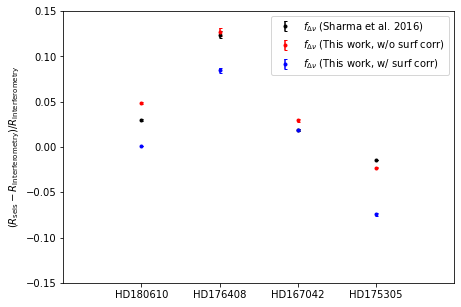

In [68]:
# 

fig, axes = plt.subplots(figsize=[7,5], nrows=1, ncols=1, squeeze=False)
axes = axes.reshape(-1)

# (Rseis-Rgaia)/Rgaia = Rseis*inv_Rgaia - 1

vals = [[sample['Rseis_S16'], sample['rad'], sample['e_Rseis_S16'], sample['rad_sig']],
        [sample['Rseis_o'], sample['rad'], sample['e_Rseis_o'], sample['rad_sig']],
        [sample['Rseis'], sample['rad'], sample['e_Rseis'], sample['rad_sig']],
        [sample['Rseis_m'], sample['rad'], sample['e_Rseis_m'], sample['rad_sig']]]

colors = ['k', 'r', 'b', 'g']
labels = ['$f_{\\Delta\\nu}$ (Sharma et al. 2016)',
         '$f_{\\Delta\\nu}$ (This work, w/o surf corr)',
         '$f_{\\Delta\\nu}$ (This work, w/ surf corr)',
         '$f_{\\Delta\\nu}$ (This work, modelling)']
for ival, [x, y, ex, ey] in enumerate(vals[:3]):
    axes[0].errorbar(range(4), (x-y)/y, yerr=(x/y-1)*((ex/x)**2. + (ey/y)**2.)**0.5, color=colors[ival], 
                     marker='.', linestyle='none', ecolor=colors[ival],
                     label=labels[ival], capsize=1.5)
#     axes[0].fill_between([1,100], [-0.02,-0.02],[0.02,0.02], color='lightgray', zorder=-10)

axes[0].set_ylim(-0.15,0.15)
axes[0].set_xlim(-1, 4)
# axes[0].set_xscale('log')
# axes[0].set_xlabel('')
axes[0].set_ylabel('$(R_{\\rm seis}-R_{\\rm Interferometry})/R_{\\rm Interferometry}$')
axes[0].set_xticks(np.arange(0,4,1))
axes[0].set_xticklabels(['HD{:0.0f}'.format(num) for num in sample['hd_id']])
axes[0].legend()

# Test new fDnu on Gaia radii

In [19]:
yu = pd.read_csv('../../database/catalog/yu+2018.csv')
yu['Dnu'], yu['e_Dnu'] = yu['Delnu'], yu['e_Delnu']
cols = ['KIC', 'Dnu', 'e_Dnu', 'numax', 'e_numax', 'Phase']
yu = yu[cols]

# sample1 = pd.read_csv('joel_gaia_radii_apokasc2_apodr16_yaguang.dat').merge(yu, how='left', on='KIC')
# sample1['flags'] = sample1['flags'].astype('str')
# idx = (sample1['flags']=='nan') & (np.isfinite(sample1['numax']))
# sample1 = sample1[idx].reset_index(drop=True)

sample = pd.read_csv('joel_gaia_radii_apokasc2_apodr16_yaguang_khan_v2.dat').merge(yu, how='left', on='KIC')
sample['flags'] = sample['flags'].astype('str')
idx = (sample['flags']=='nan') & (np.isfinite(sample['numax']))
sample = sample[idx].reset_index(drop=True)

In [20]:
# sample1.head()

In [21]:
sample.head()

,KIC,inv_r_gaia_K_MIST,inv_r_gaia_K_MIST_err,teff,teff_err,feh,feh_err,flags,Dnu,e_Dnu,numax,e_numax,Phase
0,1027337,0.123424,0.003303,4635.539062,30.0,0.231188,0.005452,nan,6.937,0.014,74.21,0.68,1.0
1,1163359,0.066577,0.002848,4578.983887,30.0,-0.413422,0.009004,nan,2.642,0.015,21.43,0.41,1.0
2,1294122,0.129339,0.002925,4805.958496,30.0,-0.054198,0.006517,nan,7.022,0.016,75.62,0.84,1.0
3,1296068,0.128174,0.003807,4586.545410,30.0,-0.010170,0.008435,nan,6.140,0.013,59.56,0.49,1.0
4,1296507,0.164257,0.005149,4913.786621,30.0,-0.018845,0.010184,nan,10.333,0.019,126.62,2.42,1.0


In [22]:
import sys
sys.path.append('/Users/yaguang/Onedrive/github/ebfpy/')
from fdnu.asfgrid import Seism

idx = sample.index>=0

Nstar = np.sum(idx)
evstate= np.ones(Nstar)
feh=sample.loc[idx,'feh'].to_numpy() #[-1.97,-1.98]
Teff=sample.loc[idx,'teff'].to_numpy() #[4659.8,4903.2]
Dnu=sample.loc[idx,'Dnu'].to_numpy() #[8.81,13.1]
numax=sample.loc[idx,'numax'].to_numpy() #[92.36,157.3]
s=Seism(datadir='fdnu/')
mass,radius=s.get_mass_radius(evstate,feh,Teff,Dnu,numax,isfeh=True)
logg=s.mr2logg(mass,radius)
_,_,fDnu=s.get_dnu_numax(evstate,feh,Teff,mass,mass,logg,isfeh=True)

sample.loc[idx,'fDnu_S16'] = fDnu

numax_sun = 3090
Teff_sun = 5777
Dnu_sun = 135.1 

radius = (sample['numax']/numax_sun)**1 * (sample['Dnu']/Dnu_sun)**-2. * sample['fDnu_S16']**2.0 * (sample['teff']/Teff_sun)**0.5
e_radius = radius * ((1*sample['e_numax']/sample['numax'])**2. + (2*sample['e_Dnu']/sample['Dnu'])**2. + (0.5*sample['teff_err']/sample['teff'])**2.)**0.5

sample['Rseis_S16'], sample['e_Rseis_S16'] = radius, e_radius

[[('logz', 'float64', ()), ('mass', 'float64', ()), ('evstate', 'float64', ()), ('logg_teff', 'float64', ()), ('logg', 'float64', ()), ('teff', 'float64', ()), ('fdnu', 'float64', ()), ('fdnu_int', 'float64', ()), ('mass_nu', 'float64', ()), ('age', 'float64', ()), ('dp', 'float64', ()), ('central_he4', 'float64', ()), ('model', 'int64', ())], [b'NULL', b'NULL', b'NULL', b'NULL', b'NULL', b'NULL', b'NULL', b'NULL', b'NULL', b'NULL', b'NULL', b'NULL', b'NULL']]
[[('logz', 'float64', ()), ('mass', 'float64', ()), ('evstate', 'float64', ()), ('logg_teff', 'float64', ()), ('logg', 'float64', ()), ('teff', 'float64', ()), ('fdnu', 'float64', ()), ('fdnu_int', 'float64', ()), ('mass_nu', 'float64', ()), ('age', 'float64', ()), ('dp', 'float64', ()), ('central_he4', 'float64', ()), ('model', 'int64', ())], [b'NULL', b'NULL', b'NULL', b'NULL', b'NULL', b'NULL', b'NULL', b'NULL', b'NULL', b'NULL', b'NULL', b'NULL', b'NULL']]
outside interp range 11  out of  2140
outside interp range 28  out of 

In [23]:
sample.head()

,KIC,inv_r_gaia_K_MIST,inv_r_gaia_K_MIST_err,teff,teff_err,feh,feh_err,flags,Dnu,e_Dnu,numax,e_numax,Phase,fDnu_S16,Rseis_S16,e_Rseis_S16
0,1027337,0.123424,0.003303,4635.539062,30.0,0.231188,0.005452,nan,6.937,0.014,74.21,0.68,1.0,0.978427,7.811366,0.082196
1,1163359,0.066577,0.002848,4578.983887,30.0,-0.413422,0.009004,nan,2.642,0.015,21.43,0.41,1.0,0.969527,15.176167,0.341279
2,1294122,0.129339,0.002925,4805.958496,30.0,-0.054198,0.006517,nan,7.022,0.016,75.62,0.84,1.0,0.980692,7.946418,0.098580
3,1296068,0.128174,0.003807,4586.545410,30.0,-0.010170,0.008435,nan,6.140,0.013,59.56,0.49,1.0,0.970041,7.824244,0.076785
4,1296507,0.164257,0.005149,4913.786621,30.0,-0.018845,0.010184,nan,10.333,0.019,126.62,2.42,1.0,0.988286,6.309918,0.124311


In [8]:
# import importlib
# importlib.reload(scaling)

In [24]:
import scaling


Npart = int(len(sample)/100+1)

for ipart in range(Npart):
    print(ipart, '/', Npart)
    idx = (sample.index>(ipart*100)) & (sample.index<((ipart+1)*100))
    Nstar = np.sum(idx)

    feh, e_feh = sample.loc[idx,'feh'].to_numpy(), sample.loc[idx,'feh_err'].to_numpy() #[-1.97,-1.98]
    Teff, e_Teff = sample.loc[idx,'teff'].to_numpy(), sample.loc[idx,'teff_err'].to_numpy() #[4659.8,4903.2]
    Dnu, e_Dnu = sample.loc[idx,'Dnu'].to_numpy(), sample.loc[idx,'e_Dnu'].to_numpy() #[8.81,13.1]
    numax, e_numax = sample.loc[idx,'numax'].to_numpy(), sample.loc[idx,'e_numax'].to_numpy() #[92.36,157.3]

    s = scaling.seismo(path_grid_models='models/fDnu/fDnu_grid.parquet') #'/Users/yaguang/fDnu/fDnu_grid.parquet'
    s.set_observables(Teff=Teff, e_Teff=e_Teff, 
                      MH=feh, e_MH=e_feh,
                      numax=numax, e_numax=e_numax, 
                      Dnu=Dnu, e_Dnu=e_Dnu)

    sample.loc[idx,'fDnu_o'], sample.loc[idx,'e_fDnu_o']  = s._get_estimators('fDnu_o')
    sample.loc[idx,'fDnu'], sample.loc[idx,'e_fDnu']  = s._get_estimators('fDnu')
    sample.loc[idx,'Rseis_m'], sample.loc[idx,'e_Rseis_m'] = s.get_radius()

0 / 22
1 / 22
2 / 22
3 / 22
4 / 22
5 / 22
6 / 22
7 / 22
8 / 22
9 / 22
10 / 22
11 / 22
12 / 22
13 / 22


/import/silo3/yali4742/numax-sc-metallicity/surface/scaling.py:128: RuntimeWarning: invalid value encountered in true_divide
  cdf /= cdf[-1]


16 / 22
17 / 22
18 / 22
19 / 22
20 / 22
21 / 22


In [25]:
# for sample in [sample1, sample2]:
radius = (sample['numax']/numax_sun)**1 * (sample['Dnu']/Dnu_sun)**-2. * sample['fDnu_o']**2.0 * (sample['teff']/Teff_sun)**0.5
e_radius = radius * ((1*sample['e_numax']/sample['numax'])**2. + (2*sample['e_Dnu']/sample['Dnu'])**2. + (0.5*sample['teff_err']/sample['teff'])**2.)**0.5
sample['Rseis_o'], sample['e_Rseis_o'] = radius, e_radius


radius = (sample['numax']/numax_sun)**1 * (sample['Dnu']/Dnu_sun)**-2. * sample['fDnu']**2.0 * (sample['teff']/Teff_sun)**0.5
e_radius = radius * ((1*sample['e_numax']/sample['numax'])**2. + (2*sample['e_Dnu']/sample['Dnu'])**2. + (0.5*sample['teff_err']/sample['teff'])**2.)**0.5
sample['Rseis'], sample['e_Rseis'] = radius, e_radius

In [26]:
# sample1.to_csv('joel_processed_data_v1.csv', index=False)
sample.to_csv('data/joel_gaia_data.csv', index=False)

In [27]:
sample = pd.read_csv('data/joel_gaia_data.csv')

In [28]:
sample.describe()

,KIC,inv_r_gaia_K_MIST,inv_r_gaia_K_MIST_err,teff,teff_err,feh,feh_err,flags,Dnu,e_Dnu,...,fDnu_o,e_fDnu_o,fDnu,e_fDnu,Rseis_m,e_Rseis_m,Rseis_o,e_Rseis_o,Rseis,e_Rseis
count,2.140000e+03,2140.000000,2140.000000,2140.000000,2140.0,2140.000000,2140.000000,0.0,2140.000000,2140.000000,...,2117.000000,2.117000e+03,2117.000000,2.117000e+03,2117.000000,2.117000e+03,2117.000000,2117.000000,2117.000000,2117.000000
mean,7.837623e+06,0.125505,0.003249,4717.570640,30.0,-0.080236,0.007281,NaN,6.777791,0.019849,...,0.980554,2.027249e-03,0.961030,1.681450e-03,8.586930,1.434984e-01,8.991166,0.165828,8.617889,0.158497
std,2.720464e+06,0.040080,0.000953,149.643185,0.0,0.248281,0.001552,NaN,3.210533,0.034606,...,0.007744,2.410609e-03,0.010614,2.286076e-03,2.804608,2.323045e-01,2.976319,0.270024,2.791395,0.257854
min,1.027337e+06,0.042174,0.001093,4223.438965,30.0,-1.495162,0.004830,NaN,2.015000,0.008000,...,0.947114,1.410322e-11,0.928911,8.132123e-11,4.105291,1.225729e-08,4.359063,0.024774,4.172770,0.023715
25%,5.638926e+06,0.096542,0.002527,4618.061157,30.0,-0.233752,0.006187,NaN,4.485000,0.013000,...,0.975549,1.704660e-04,0.954172,1.119115e-04,6.400205,5.559934e-03,6.674065,0.060813,6.430391,0.058668
50%,8.144498e+06,0.118841,0.003152,4709.326904,30.0,-0.062400,0.006972,NaN,5.879000,0.015000,...,0.979974,1.524818e-03,0.960304,1.147137e-03,8.189079,7.257981e-02,8.575509,0.100283,8.228986,0.096414
75%,1.006426e+07,0.153675,0.003918,4817.334351,30.0,0.095842,0.007953,NaN,8.900500,0.018000,...,0.985416,2.966534e-03,0.968695,2.364212e-03,10.030550,1.892904e-01,10.592623,0.163907,10.109409,0.157521
max,1.288412e+07,0.227854,0.006952,5238.285645,30.0,0.457278,0.017615,NaN,15.042000,1.096000,...,1.043302,2.682960e-02,1.031457,2.776392e-02,19.161880,2.614663e+00,20.520309,5.483637,20.043939,5.295234


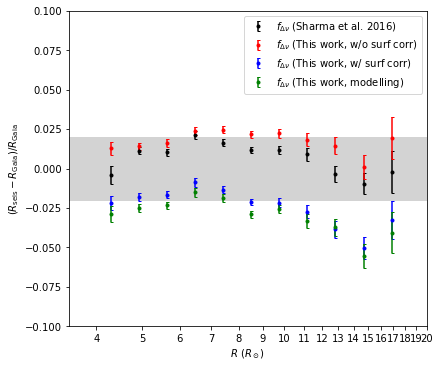

In [29]:
fig, axes = plt.subplots(figsize=[6,5], nrows=1, ncols=1, squeeze=False, constrained_layout=True)
# axes = axes.reshape(-1)

# (Rseis-Rgaia)/Rgaia = Rseis*inv_Rgaia - 1
isa = 0
idx = sample['Phase']==1
sample = sample.loc[idx,:]

vals = [[sample['Rseis'], sample['Rseis_S16']*sample['inv_r_gaia_K_MIST']-1],
        [sample['Rseis'], sample['Rseis_o']*sample['inv_r_gaia_K_MIST']-1],
        [sample['Rseis'], sample['Rseis']*sample['inv_r_gaia_K_MIST']-1],
        [sample['Rseis'], sample['Rseis_m']*sample['inv_r_gaia_K_MIST']-1]]

colors = ['k', 'r', 'b', 'g']
labels = ['$f_{\\Delta\\nu}$ (Sharma et al. 2016)',
         '$f_{\\Delta\\nu}$ (This work, w/o surf corr)',
         '$f_{\\Delta\\nu}$ (This work, w/ surf corr)',
         '$f_{\\Delta\\nu}$ (This work, modelling)']
for ival, [x, y] in enumerate(vals[:4]):
#     axes[0].scatter(x, y, color=colors[ival], marker='.')
    xcs, medians, stds = se.get_binned_median(x, y, np.logspace(np.log10(4), np.log10(18), 12))
    axes[0,isa].errorbar(xcs, medians, yerr=stds, color=colors[ival], 
                     marker='.', linestyle='none', ecolor=colors[ival],
                     label=labels[ival], capsize=1.5)
    axes[0,isa].fill_between([1,100], [-0.02,-0.02],[0.02,0.02], color='lightgray', zorder=-10)

axes[0,isa].set_ylim(-0.1,0.1)
axes[0,isa].set_xlim(3.5, 20)
axes[0,isa].set_xscale('log')
axes[0,isa].set_xlabel('$R$ ($R_\\odot$)')
axes[0,isa].set_ylabel('$(R_{\\rm seis}-R_{\\rm Gaia})/R_{\\rm Gaia}$')
axes[0,isa].set_xticks(np.arange(4,21,1))
axes[0,isa].set_xticklabels(['{:0.0f}'.format(num) for num in np.arange(4,21,1)])
axes[0,isa].legend()

In [48]:
stars[

,index,KIC,ifsplitting,ifmodelling,ifsupressed,comments,stage,names,_RA,_DE,...,ClcorR,e_ClcorR,Phase,rgeo,b_rgeo,B_rgeo,rpgeo,b_rpgeo,B_rpgeo,ebv
0,0,1,NaN,1,0.0,NaN,esg,mu Her,266.61469,27.720621,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000
1,1,2991448,-1.0,1,0.0,NaN,esg,NaN,291.82490,38.113190,...,NaN,NaN,NaN,284.446259,275.085693,294.698334,277.899567,269.653534,288.931915,0.000000
2,3,4346201,-1.0,1,0.0,NaN,esg,NaN,285.28595,39.498050,...,NaN,NaN,NaN,243.909912,240.919601,247.180618,243.758667,240.746506,246.525421,0.000000
3,5,5607242,1.0,1,0.0,NaN,esg,NaN,287.64633,40.843060,...,NaN,NaN,NaN,333.288605,330.581085,335.470886,334.051239,331.574921,336.558716,0.009525
4,6,5689820,1.0,1,0.0,NaN,esg,NaN,286.22723,40.927730,...,NaN,NaN,NaN,337.830200,336.491333,339.050110,337.934021,336.425781,339.318787,0.010000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1289,1345,8430105,NaN,1,NaN,NaN,rgb,binary,291.55862,44.488190,...,NaN,NaN,NaN,725.739441,720.955627,731.051331,728.149170,721.238159,734.125183,0.060000
1290,1346,9153621,NaN,1,NaN,NaN,rgb,binary,291.41193,45.535190,...,NaN,NaN,NaN,2758.102050,2664.918950,2839.514650,2773.542480,2678.918700,2859.215330,0.050000
1291,1348,9540226,NaN,1,NaN,NaN,rgb,binary,297.03400,46.198470,...,14.43,0.88,0.0,1772.660160,1737.486330,1813.271120,1762.313230,1736.620240,1788.380490,0.130000
1292,1349,9970396,NaN,1,NaN,NaN,rgb,binary,298.70980,46.833030,...,NaN,NaN,NaN,977.215210,956.965759,992.817871,979.437073,963.291260,993.985168,0.176391


In [ ]:
data = stars.loc[stars['Phase']==1, ['KIC','Teff', '[M/H]', 'lum_K']]
data = data.merge(sample2[['KIC', 'teff', 'feh', 'inv_r_gaia_K_MIST']], on='KIC')
data['lum'] = (1/data['inv_r_gaia_K_MIST'])**2.0 * (data['teff']/5777.)**4.0

fig, axes = plt.subplots(figsize=[20,5], nrows=1, ncols=3, squeeze=True)
axes[0].hist(data['Teff']-data['teff'], bins=np.linspace(-500, 500, 50) )
axes[0].set_xlabel('Difference in Teff')
axes[0].set_title('DTeff: {:0.0f} +/- {:0.0f}'.format(np.median(data['Teff']-data['teff']), np.std(data['Teff']-data['teff'])))

axes[1].hist(data['[M/H]']-data['feh'], bins=np.linspace(-0.5, 0.5, 50) )
axes[1].set_xlabel('Difference in feh')
axes[1].set_title('Dfeh: {:0.2f} +/- {:0.2f}'.format(np.median(data['[M/H]']-data['feh']), np.std(data['[M/H]']-data['feh'])))

axes[2].hist(data['lum_K']-data['lum'], bins=np.linspace(-10, 10, 50) )
axes[2].set_xlabel('Difference in lum')
axes[2].set_title('Dlum: {:0.1f} +/- {:0.1f}'.format(np.median(data['lum_K']-data['lum']), np.std(data['lum_K']-data['lum'])))

Text(0.5, 1.0, 'Dlum: 0.1 +/- 0.7')

0        8.064437
1       14.918959
2        7.709542
3        7.693599
4        5.999408
          ...    
2127    14.124301
2128    10.141845
2129    14.351775
2130     9.151051
2131     8.541319
Name: inv_r_gaia_K_MIST, Length: 2132, dtype: float64

# Test new fDnu on binaries

Not sure this is a good idea, because individual measurements have large uncertainties.

Let's try anyway

In [32]:
idx = np.isin(stars['names'], ['binary']) #& (stars['ruwe']<1.2)#ngc6
sample = stars.loc[idx,:].reset_index(drop=True)

In [33]:
sample[['[M/H]','e_[M/H]', 'Teff', 'e_Teff', 'Dnu', 'e_Dnu', 'numax', 'e_numax']]
sample[['[Fe/H]_B21','e_[Fe/H]_B21', 'Teff_B21', 'e_Teff_B21', 'Dnu', 'e_Dnu', 'numax', 'e_numax']]

,[Fe/H]_B21,e_[Fe/H]_B21,Teff_B21,e_Teff_B21,Dnu,e_Dnu,numax,e_numax
0,-0.13,0.06,4812.0,92.0,5.239280,0.017769,54.09,2.7045
1,-0.29,0.09,4525.0,75.0,NaN,NaN,24.10,1.2050
2,-0.06,0.06,4747.0,100.0,3.484195,0.023857,29.75,1.4875
3,-0.34,0.01,4500.0,80.0,2.711862,0.032317,21.75,1.0875
4,0.16,0.03,4699.0,91.0,4.673415,0.028708,46.00,2.3000
5,-0.49,0.04,5042.0,68.0,NaN,NaN,76.70,3.8350
6,-0.30,0.20,4760.0,190.0,NaN,NaN,38.22,1.9110
7,-0.33,0.04,4680.0,80.0,3.122528,0.014248,27.07,1.3535
8,-0.23,0.03,4860.0,80.0,6.217648,0.051371,63.70,3.1850
9,-0.69,0.04,4700.0,66.0,NaN,NaN,19.90,0.9950


In [34]:
import scaling

Npart = int(len(sample)/100+1)

for ipart in range(Npart):
    print(ipart)
    idx = (sample.index>(ipart*100)) & (sample.index<((ipart+1)*100))
    Nstar = np.sum(idx)

#     feh, e_feh = sample.loc[idx,'[M/H]'].to_numpy(), sample.loc[idx,'e_[M/H]'].to_numpy() #[-1.97,-1.98]
#     Teff, e_Teff = sample.loc[idx,'Teff'].to_numpy(), sample.loc[idx,'e_Teff'].to_numpy() #[4659.8,4903.2]
    feh, e_feh = sample.loc[idx,'[Fe/H]_B21'].to_numpy(), sample.loc[idx,'e_[Fe/H]_B21'].to_numpy() #[-1.97,-1.98]
    Teff, e_Teff = sample.loc[idx,'Teff_B21'].to_numpy(), sample.loc[idx,'e_Teff_B21'].to_numpy() #[4659.8,4903.2]
    Dnu, e_Dnu = sample.loc[idx,'Dnu'].to_numpy(), sample.loc[idx,'e_Dnu'].to_numpy() #[8.81,13.1]
    numax, e_numax = sample.loc[idx,'numax'].to_numpy(), sample.loc[idx,'e_numax'].to_numpy() #[92.36,157.3]

    s = scaling.seismo(path_grid_models='models/fDnu/fDnu_grid.parquet')
    s.set_observables(Teff=Teff, e_Teff=e_Teff, 
                      MH=feh, e_MH=e_feh,
                      numax=numax, e_numax=e_numax, 
                      Dnu=Dnu, e_Dnu=e_Dnu)

    sample.loc[idx,'fDnu_o'], sample.loc[idx,'e_fDnu_o']  = s._get_estimators('fDnu_o')
    sample.loc[idx,'fDnu'], sample.loc[idx,'e_fDnu']  = s._get_estimators('fDnu')

0


In [35]:
sample['Dnu'] = sample['Dnu_guess']
sample['e_Dnu'] = 0.017768551/5.239279672 * sample['Dnu']

In [36]:
# syd pipeline reference values 
numax_sun = 3090
Teff_sun = 5777
Dnu_sun = 135.1 
# # Benbakoura+21 referenc values
# numax_sun = 3227
# Teff_sun = 5771.8
# Dnu_sun = 132.9

sTeff = 'Teff_B21'
seTeff = 'e_Teff_B21'

radius = (sample['numax']/numax_sun)**1 * (sample['Dnu']/Dnu_sun)**-2. * sample['fDnu_o']**2.0 * (sample[sTeff]/Teff_sun)**0.5
e_radius = radius * ((1*sample['e_numax']/sample['numax'])**2. + (2*sample['e_Dnu']/sample['Dnu'])**2. + (0.5*sample[seTeff]/sample[sTeff])**2.)**0.5
sample['radius_sc'], sample['e_radius_sc'] = radius, e_radius

mass = (sample['numax']/numax_sun)**3 * (sample['Dnu']/Dnu_sun)**-4. * sample['fDnu_o']**4.0 * (sample[sTeff]/Teff_sun)**1.5
e_mass = mass * ((3*sample['e_numax']/sample['numax'])**2. + (4*sample['e_Dnu']/sample['Dnu'])**2. + (1.5*sample[seTeff]/sample[sTeff])**2.)**0.5
sample['mass_sc'], sample['e_mass_sc'] = mass, e_mass


radius = (sample['numax']/numax_sun)**1 * (sample['Dnu']/Dnu_sun)**-2. * sample['fDnu']**2.0 * (sample[sTeff]/Teff_sun)**0.5
e_radius = radius * ((1*sample['e_numax']/sample['numax'])**2. + (2*sample['e_Dnu']/sample['Dnu'])**2. + (0.5*sample[seTeff]/sample[sTeff])**2.)**0.5
sample['radius_scf'], sample['e_radius_scf'] = radius, e_radius

mass = (sample['numax']/numax_sun)**3 * (sample['Dnu']/Dnu_sun)**-4. * sample['fDnu']**4.0 * (sample[sTeff]/Teff_sun)**1.5
e_mass = mass * ((3*sample['e_numax']/sample['numax'])**2. + (4*sample['e_Dnu']/sample['Dnu'])**2. + (1.5*sample[seTeff]/sample[sTeff])**2.)**0.5
sample['mass_scf'], sample['e_mass_scf'] = mass, e_mass

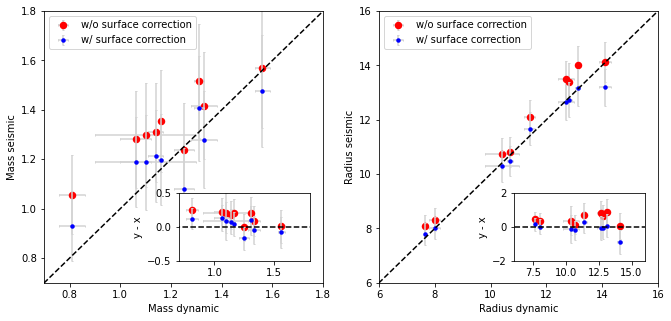

In [37]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

fig, axes = plt.subplots(figsize=(11,5), nrows=1, ncols=2, squeeze=False)
# axes = axes.reshape(-1)

styles = {'linestyle':'none', 'mec':'none', 'capsize':1, 'marker':'.'}

rows = ['sc', 'scf']
cols = ['mass', 'radius']
irow = 0
for icol in range(2):
    col = cols[icol]
    x, ex = sample['{:s}_dyn'.format(col)], sample['e_{:s}_dyn'.format(col)]
    y1, ey1 = sample['{:s}_{:s}'.format(col, 'sc')], sample['e_{:s}_{:s}'.format(col, 'sc')]
    y2, ey2 = sample['{:s}_{:s}'.format(col, 'scf')], sample['e_{:s}_{:s}'.format(col, 'scf')]

    axes[irow, icol].errorbar(x, y1, 
                     xerr=ex, yerr=ey1, 
                     label='w/o surface correction', mfc='r', ms=15, zorder=-1, ecolor='lightgray', **styles)
    axes[irow, icol].errorbar(x, y2, 
                     xerr=ex, yerr=ey2, 
                     label='w/ surface correction', mfc='b', ms=9, zorder=1, ecolor='lightgray', **styles)

    axins = inset_axes(axes[irow, icol], width="100%", height="100%",
               bbox_to_anchor=(.5, .1, .47, .25), # bbox to anchor starts at (1, 2), ranges at (3, 4)
                bbox_transform=axes[irow, icol].transAxes) 

    axins.errorbar(x, y1-x, 
                     xerr=ex, yerr=(ey1**2.+ex**2.)**0.5, 
                     mfc='r', ms=15, zorder=-1, ecolor='lightgray', **styles)
    axins.errorbar(x, y2-x, 
                     xerr=ex, yerr=(ey2**2.+ex**2.)**0.5, 
                     mfc='b', ms=9, zorder=1, ecolor='lightgray', **styles)
    axins.set_ylabel('y - x')
    axins.plot([0., 100.], [0., 0.], 'k--')

    if icol==0: # mass col
        axins.axis([0.7, 1.8, -0.5, 0.5])
        axes[irow,icol].axis([0.7, 1.8, 0.7, 1.8])
        axes[irow,icol].plot([0.1, 10.], [0.1, 10.], 'k--')
        axes[irow,icol].set_xlabel('Mass dynamic')
        axes[irow,icol].set_ylabel('Mass seismic')
        axes[irow,icol].legend(loc='upper left')
    else: # radius col
        axins.axis([6, 16, -2., 2.])
        axes[irow,icol].axis([6, 16, 6, 16])
        axes[irow,icol].plot([0.1, 100.], [0.1, 100.], 'k--')
        axes[irow,icol].set_xlabel('Radius dynamic')
        axes[irow,icol].set_ylabel('Radius seismic')
        axes[irow,icol].legend(loc='upper left')

In [38]:
sample.to_csv('data/EBs_data.csv',index=False)

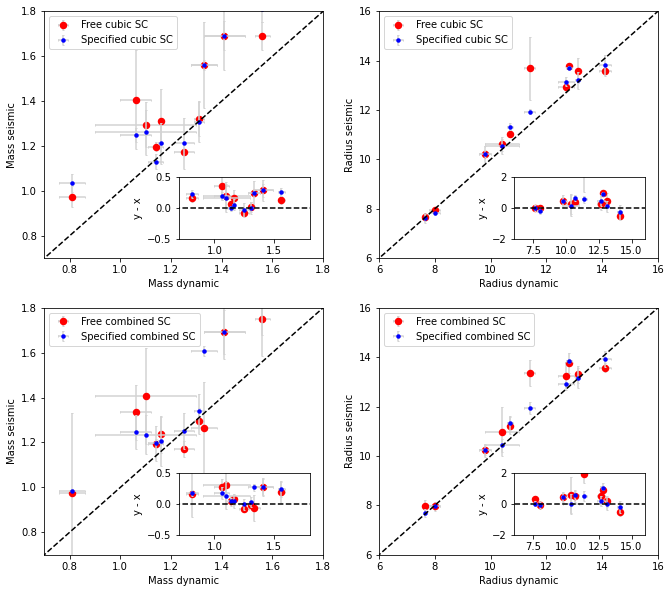

In [31]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

fig, axes = plt.subplots(figsize=(11,10), nrows=2, ncols=2, squeeze=False)
# axes = axes.reshape(-1)

styles = {'linestyle':'none', 'mec':'none', 'capsize':1, 'marker':'.'}

rows = ['cubic', 'combined']
cols = ['mass', 'radius']
for irow in range(2):
    for icol in range(2):
        row, col = rows[irow], cols[icol]
        x, ex = sample['{:s}_dyn'.format(col)], sample['e_{:s}_dyn'.format(col)]
        y1, ey1 = sample['{:s}_{:s}'.format(col, row)], sample['e_{:s}_{:s}'.format(col, row)]
        y2, ey2 = sample['{:s}_{:s}_linear'.format(col, row)], sample['e_{:s}_{:s}_linear'.format(col, row)]
        
        axes[irow, icol].errorbar(x, y1, 
                         xerr=ex, yerr=ey1, 
                         label='Free {:s} SC'.format(row), mfc='r', ms=15, zorder=-1, ecolor='lightgray', **styles)
        axes[irow, icol].errorbar(x, y2, 
                         xerr=ex, yerr=ey2, 
                         label='Specified {:s} SC'.format(row), mfc='b', ms=9, zorder=1, ecolor='lightgray', **styles)

        axins = inset_axes(axes[irow, icol], width="100%", height="100%",
                   bbox_to_anchor=(.5, .1, .47, .25), # bbox to anchor starts at (1, 2), ranges at (3, 4)
                    bbox_transform=axes[irow, icol].transAxes) 
        
        axins.errorbar(x, y1-x, 
                         xerr=ex, yerr=(ey1**2.+ex**2.)**0.5, 
                         mfc='r', ms=15, zorder=-1, ecolor='lightgray', **styles)
        axins.errorbar(x, y2-x, 
                         xerr=ex, yerr=(ey2**2.+ex**2.)**0.5, 
                         mfc='b', ms=9, zorder=1, ecolor='lightgray', **styles)
        axins.set_ylabel('y - x')
        axins.plot([0., 100.], [0., 0.], 'k--')
        
        if icol==0: # mass col
            axins.axis([0.7, 1.8, -0.5, 0.5])
            axes[irow,icol].axis([0.7, 1.8, 0.7, 1.8])
            axes[irow,icol].plot([0.1, 10.], [0.1, 10.], 'k--')
            axes[irow,icol].set_xlabel('Mass dynamic')
            axes[irow,icol].set_ylabel('Mass seismic')
            axes[irow,icol].legend(loc='upper left')
        else: # radius col
            axins.axis([6, 16, -2., 2.])
            axes[irow,icol].axis([6, 16, 6, 16])
            axes[irow,icol].plot([0.1, 100.], [0.1, 100.], 'k--')
            axes[irow,icol].set_xlabel('Radius dynamic')
            axes[irow,icol].set_ylabel('Radius seismic')
            axes[irow,icol].legend(loc='upper left')

In [20]:
1/(1.0*11.574*1e-6) #muHz->Hz # second


86400.55296353897

In [18]:
numax = 1

np.log10((numax/3090) * np.sqrt(3500/5777) * 27400)


0.8389749217999848